# Email AutoLabeler

### Data Set:
The Enron email dataset contains 517401 emails generated by 150 employees of the Enron Corporation, mostly senior management of Enron, organized into folders. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse. This dataset does not include attachments. Invalid email addresses were converted to something of the form user@enron.com whenever possible (i.e., recipient is specified in some parse-able format like "Doe, John" or "Mary K. Smith") and to no_address@enron.com when no recipient was specified.

https://www.cs.cmu.edu/~./enron/ May 7, 2015 Version 

In [1399]:
import email, re
import numpy as np 
import pandas as pd
from pandas.core.common import flatten
import pickle
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from imblearn.under_sampling import RandomUnderSampler 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

# 1. Load and clean data

## Data information

In [3]:
# Read the data into a DataFrame
df_emails = pd.read_csv('../Data/emails.csv')
print("There are total {} emails.".format(df_emails.shape[0]))

There are total 517401 emails.


In [4]:
#Show the first 5 emails in the data frame.
df_emails.head(5)

file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

In [8]:
#Show the message of a sample email. 
print(df_emails['message'][10471])

Message-ID: <27086631.1075854806617.JavaMail.evans@thyme>
Date: Tue, 24 Oct 2000 02:57:00 -0700 (PDT)
From: eric.bass@enron.com
To: shanna.husser@enron.com
Subject: Re: It could happen!!!
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Eric Bass
X-To: Shanna Husser
X-cc: 
X-bcc: 
X-Folder: \Eric_Bass_Jun2001\Notes Folders\'sent mail
X-Origin: Bass-E
X-FileName: ebass.nsf

Thought you might like Superfan's comments.
---------------------- Forwarded by Eric Bass/HOU/ECT on 10/24/2000 09:56 AM 
---------------------------
   
	Enron North America Corp.
	
	From:  Eric Bass                           10/24/2000 09:53 AM
	

To: Chad Landry/HOU/ECT@ECT
cc: Matthew Lenhart/HOU/ECT@ECT, Christopher Coffman/Corp/Enron@Enron, 
William Kelly/HOU/ECT@ECT, Kyle Etter/HOU/ECT@ECT, Kam Keiser/HOU/ECT@ECT, 
Jay Reitmeyer/HOU/ECT@ECT, Jeff Coates/HOU/ECT@ECT, William 
Keeney/HOU/ECT@ECT, Jeffrey C Gossett/HOU/ECT@ECT, John King/HOU/ECT@ECT, 
Luis Mena/

We can see that the headers include Message-ID, Date, From, To, Cc, Bcc, Subject, Mime-Version, Content-Type, Content-Transfer-Encoding, X-From, X-To, X-cc, X-bcc, X-Folder, X-Origin, X-FileName, and message body. We are only interested in the headers: X-Origin (i.e.,Employee Name), Date, From, To, Cc, Bcc, Subject, message body, and X-Folder.

## Parse email messages

In [5]:
# Helper functions
def get_message_body(msg):
    '''To get the message body from email headers'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append(re.sub('\n|\t', ' ', part.get_payload()).strip()  )        
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = list(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

def drop_none(line):
    '''To drop None from email list and sort the list'''
    return sorted(list([a for a in line if a]))

In [10]:
headers = list(map(email.message_from_string, df_emails['message']))
headers_sel = ["X-Origin", "Date", "From", "To", "Cc", "Bcc", "Subject", "X-Folder"]
for key in headers_sel:
    df_emails[key] = [message[key] for message in headers]
df_emails.columns

Index(['file', 'message', 'X-Origin', 'Date', 'From', 'To', 'Cc', 'Bcc',
       'Subject', 'X-Folder'],
      dtype='object')

In [18]:
# Get 'Employee', 'Folder' and 'Email Number' from 'file'
email_folder = df_emails['file'].apply(lambda x: x.split('/'))
Employee,Folder,Email_Number=[],[],[]
for i in email_folder.index:
    Employee.append(email_folder[i][0])
    Folder.append('/'.join(email_folder[i][1:-1]))
    Email_Number.append(email_folder[i][-1])
df_emails['Employee'], df_emails['Folder'], df_emails['Email Number'] = Employee, Folder, Email_Number

# Get 'Body' from headers
df_emails['Body'] = list(map(get_message_body, headers))

# Creat "Related Parties" 
df_emails['From'] = df_emails['From'].map(split_email_addresses)
df_emails['To'] = df_emails['To'].map(split_email_addresses)
df_emails['Cc'] = df_emails['Cc'].map(split_email_addresses)
df_emails['Bcc'] = df_emails['Bcc'].map(split_email_addresses)
df_emails["Related Parties"] =[set(flatten([df_emails["From"][a],df_emails["To"][a],df_emails["Cc"][a],df_emails["Bcc"][a]])) for a in range(len(df_emails["To"])) ]
df_emails["Related Parties"] = df_emails["Related Parties"].map(drop_none)

# Convert 'Date' format
df_emails['Date'] = pd.to_datetime(df_emails['Date'])

df_emails.head()

file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message X-Origin  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...  Allen-P   
1  Message-ID: <15464986.1075855378456.JavaMail.e...  Allen-P   
2  Message-ID: <24216240.1075855687451.JavaMail.e...  Allen-P   
3  Message-ID: <13505866.1075863688222.JavaMail.e...  Allen-P   
4  Message-ID: <30922949.1075863688243.JavaMail.e...  Allen-P   

                       Date                       From  \
0 2001-05-14 16:39:00-07:00  [phillip.allen@enron.com]   
1 2001-05-04 13:51:00-07:00  [phillip.allen@enron.com]   
2 2000-10-18 03:00:00-07:00  [phillip.allen@enron.com]   
3 2000-10-23 06:13:00-07:00  [phillip.allen@enron.com]   
4 2000-08-31 05:07:00-07:00  [phillip.allen@enron.com]   

                          To    Cc   Bcc    Subject  \
0     [tim.belden@enron.com]  None  None              
1  [john.lavorato@enron.com]  None  None        Re:   
2   [leah.arsdall@enron.com]  None  None   Re: test   
3    [randall.gay@enron.com]  None  None              
4     [greg.piper@enron.com]  None  None  Re: Hello   

                                            X-Folder Employee      Folder  \
0  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  allen-p  _sent_mail   
1  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  allen-p  _sent_mail   
2    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  allen-p  _sent_mail   
3    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  allen-p  _sent_mail   
4    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  allen-p  _sent_mail   

  Email Number                                               Body  \
0           1.                               Here is our forecast   
1          10.  Traveling to have a business meeting takes the...   
2         100.                     test successful.  way to go!!!   
3        1000.  Randy,   Can you send me a schedule of the sal...   
4        1001.                  Let's shoot for Tuesday at 11:45.   

                                     Related Parties  
0    [phillip.allen@enron.com, tim.belden@enron.com]  
1  [john.lavorato@enron.com, phillip.allen@enron....  
2  [leah.arsdall@enron.com, phillip.allen@enron.com]  
3   [phillip.allen@enron.com, randall.gay@enron.com]  
4    [greg.piper@enron.com, phillip.allen@enron.com]

In [22]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 15 columns):
file               517401 non-null object
message            517401 non-null object
X-Origin           517372 non-null object
Date               517401 non-null datetime64[ns, tzlocal()]
From               517401 non-null object
To                 495554 non-null object
Cc                 127881 non-null object
Bcc                127881 non-null object
Subject            517401 non-null object
X-Folder           517372 non-null object
Employee           517401 non-null object
Folder             517401 non-null object
Email Number       517401 non-null object
Body               517401 non-null object
Related Parties    517401 non-null object
dtypes: datetime64[ns, tzlocal()](1), object(14)
memory usage: 59.2+ MB


In [23]:
# Check missing values
print('Check missing values:\n', df_emails.isnull().sum())

Check missing values:
 file                    0
message                 0
X-Origin               29
Date                    0
From                    0
To                  21847
Cc                 389520
Bcc                389520
Subject                 0
X-Folder               29
Employee                0
Folder                  0
Email Number            0
Body                    0
Related Parties         0
dtype: int64


In [27]:
df_emails.drop(['To', 'Cc','Bcc', 'X-Origin'], axis=1, inplace=True)
df_emails.dropna(axis=0, inplace=True)
df_emails.isna().sum()

file               0
message            0
Date               0
From               0
Subject            0
X-Folder           0
Employee           0
Folder             0
Email Number       0
Body               0
Related Parties    0
dtype: int64

In [28]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517372 entries, 0 to 517400
Data columns (total 11 columns):
file               517372 non-null object
message            517372 non-null object
Date               517372 non-null datetime64[ns, tzlocal()]
From               517372 non-null object
Subject            517372 non-null object
X-Folder           517372 non-null object
Employee           517372 non-null object
Folder             517372 non-null object
Email Number       517372 non-null object
Body               517372 non-null object
Related Parties    517372 non-null object
dtypes: datetime64[ns, tzlocal()](1), object(10)
memory usage: 47.4+ MB


In [29]:
df_emails.head()

file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <15464986.1075855378456.JavaMail.e...   
2  Message-ID: <24216240.1075855687451.JavaMail.e...   
3  Message-ID: <13505866.1075863688222.JavaMail.e...   
4  Message-ID: <30922949.1075863688243.JavaMail.e...   

                       Date                       From    Subject  \
0 2001-05-14 16:39:00-07:00  [phillip.allen@enron.com]              
1 2001-05-04 13:51:00-07:00  [phillip.allen@enron.com]        Re:   
2 2000-10-18 03:00:00-07:00  [phillip.allen@enron.com]   Re: test   
3 2000-10-23 06:13:00-07:00  [phillip.allen@enron.com]              
4 2000-08-31 05:07:00-07:00  [phillip.allen@enron.com]  Re: Hello   

                                            X-Folder Employee      Folder  \
0  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  allen-p  _sent_mail   
1  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  allen-p  _sent_mail   
2    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  allen-p  _sent_mail   
3    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  allen-p  _sent_mail   
4    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  allen-p  _sent_mail   

  Email Number                                               Body  \
0           1.                               Here is our forecast   
1          10.  Traveling to have a business meeting takes the...   
2         100.                     test successful.  way to go!!!   
3        1000.  Randy,   Can you send me a schedule of the sal...   
4        1001.                  Let's shoot for Tuesday at 11:45.   

                                     Related Parties  
0    [phillip.allen@enron.com, tim.belden@enron.com]  
1  [john.lavorato@enron.com, phillip.allen@enron....  
2  [leah.arsdall@enron.com, phillip.allen@enron.com]  
3   [phillip.allen@enron.com, randall.gay@enron.com]  
4    [greg.piper@enron.com, phillip.allen@enron.com]

In [31]:
# Write to file
f_myfile = open('dfemails_cleaned.pickle', 'wb')
pickle.dump(df_emails, f_myfile)
f_myfile.close()

In [701]:
# Load the dataframe
#with open('./SavedData/dfemails_cleaned.pickle', 'rb') as pickle_file:
#   df_emails = pickle.load(pickle_file)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x1b178d5710>>
Traceback (most recent call last):
  File "/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1448, in __del__
    def __del__(self):
KeyboardInterrupt


# 2. Exploratory Data Analysis

In [32]:
# Number of emails by Employee
df_emails.groupby(['Employee']).count().sort_values(by='file', ascending=False)['message'][0:40]

Employee
kaminski-v       28463
dasovich-j       28234
kean-s           25351
mann-k           23381
jones-t          19950
shackleton-s     18687
taylor-m         13875
farmer-d         13032
germany-c        12436
beck-s           11830
symes-k          10827
nemec-g          10655
scott-s           8022
rogers-b          8009
bass-e            7823
sanders-r         7329
campbell-l        6489
shapiro-r         6071
guzman-m          6054
lay-k             5937
lenhart-m         5919
lokay-m           5568
kitchen-l         5545
haedicke-m        5245
sager-e           5199
love-p            5002
arnold-j          4898
fossum-d          4796
perlingiere-d     4778
lavorato-j        4685
mcconnell-m       4542
giron-d           4220
skilling-j        4139
shankman-j        3856
hain-m            3820
delainey-d        3566
williams-w3       3440
blair-l           3415
mclaughlin-e      3353
whalley-l         3335
Name: message, dtype: int64

In [33]:
# Number of emails by folder
df_emails.groupby(['Employee','Folder']).count().sort_values(by='file', ascending=False)['message'][0:60]

Employee       Folder            
dasovich-j     all_documents         11896
jones-t        all_documents          9304
shackleton-s   all_documents          8158
dasovich-j     notes_inbox            7194
kaminski-v     all_documents          7174
mann-k         all_documents          6647
kaminski-v     discussion_threads     5550
taylor-m       all_documents          5229
jones-t        notes_inbox            5095
mann-k         discussion_threads     4965
kean-s         calendar/untitled      4478
               archiving/untitled     4477
               all_documents          4477
mann-k         sent                   4440
nemec-g        all_documents          4231
mann-k         _sent_mail             4220
dasovich-j     sent                   3930
jones-t        sent                   3810
shackleton-s   sent                   3774
kean-s         discussion_threads     3733
farmer-d       all_documents          3660
kaminski-v     _sent_mail             3464
               sent 

In [36]:
df_emails.groupby(['Employee','Folder']).count().sort_values(by='file', ascending=False)['message'][61:120]

Employee      Folder             
stclair-c     all_documents          1523
shapiro-r     deleted_items          1468
nemec-g       inbox                  1466
dasovich-j    sent_items             1436
bass-e        _sent_mail             1409
fossum-d      all_documents          1405
williams-w3   schedule_crawler       1398
dasovich-j    inbox                  1387
bass-e        discussion_threads     1386
steffes-j     sent_items             1379
lay-k         inbox                  1373
bass-e        sent                   1363
lewis-a       deleted_items          1359
germany-c     sent_items             1353
hain-m        all_documents          1347
stclair-c     sent                   1328
symes-k       sent                   1326
lokay-m       all_documents          1324
symes-k       _sent_mail             1323
kean-s        sent                   1315
campbell-l    inbox                  1315
shapiro-r     all_documents          1270
skilling-j    inbox                  1252


In [52]:
# Folders of employee'farmer-d'
df_emails[df_emails['Employee']=='farmer-d'].groupby('Folder').count().sort_values(by='file', ascending=False)['message']

Folder
all_documents                    3660
discussion_threads               3387
logistics                        1192
_sent_mail                        747
sent                              710
tufco                             609
deleted_items                     378
wellhead                          339
personal                          321
sent_items                        258
industrials                       236
pan_energy_swap                   164
cleburne_plant____cornhusker_     148
ces                               141
enron_news                        134
deleted_items/personal            104
entex                             102
inbox                              85
cornhusker                         67
unify                              37
resumes                            27
bankruptcy                         23
sitara                             20
contracts                          18
term_proposals                     18
calendar                           14
eol  

In [37]:
# Folders of employee 'kaminski-v'
df_emails[df_emails['Employee']=='kaminski-v'].groupby('Folder').count().sort_values(by='file', ascending=False)['message']

Folder
all_documents                         7174
discussion_threads                    5550
_sent_mail                            3464
sent                                  3463
deleted_items                         1792
sent_items                            1696
inbox                                  560
resumes                                547
c/mangmt/group/management              526
c/technote/mail/projects               379
universities                           367
c/mangmt/ene_ect                       288
personal                               281
c/mangmt/group/software/management     276
conferences                            223
notes_inbox                            223
london                                 195
c/technote/mail/techmemos              187
rice                                   175
australia                              112
var                                    110
eci/eci                                108
ut                                      76
stan

In [51]:
# Delete folders which are not created by users
folder_del = ['_sent_mail','all_documents','calendar', 'deleted_items','discussion_threads','inbox','sent','notes_inbox','sent_items']
for fd in folder_del:
    df_emails.drop(df_emails[df_emails['Folder']==fd].index, axis=0, inplace=True)

# Number of emails by Employee
df_emails.groupby(['Employee']).count().sort_values(by='file', ascending=False)['message'][0:40]

Employee
kean-s           14505
kaminski-v        4481
kitchen-l         4033
farmer-d          3786
williams-w3       2775
lokay-m           2554
taylor-m          2477
shapiro-r         2036
beck-s            2013
symes-k           1861
mann-k            1623
germany-c         1507
blair-l           1494
rogers-b          1396
sanders-r         1259
stokley-c         1252
shackleton-s      1074
watson-k          1057
baughman-d        1047
white-s            951
hyvl-d             898
griffith-j         861
dasovich-j         822
steffes-j          815
hyatt-k            772
corman-s           724
scott-s            647
wolfe-j            639
schoolcraft-d      637
mcconnell-m        586
mclaughlin-e       579
ring-r             572
quigley-d          564
ward-k             551
donoho-l           514
scholtes-d         507
davis-d            459
hayslett-r         448
campbell-l         446
mckay-j            432
Name: message, dtype: int64

In [53]:
# Number of emails by folder
df_emails.groupby(['Employee','Folder']).count().sort_values(by='file', ascending=False)['message'][0:60]

Employee       Folder                               
kean-s         calendar/untitled                        4478
               archiving/untitled                       4477
               attachments                              2026
williams-w3    schedule_crawler                         1398
farmer-d       logistics                                1192
lokay-m        tw_commercial_group                      1159
blair-l        meetings                                 1120
williams-w3    bill_williams_iii                        1022
symes-k        deal_communication/deal_discrepancies     897
white-s        meetings                                  738
kitchen-l      _americas/esvl                            715
kean-s         california                                682
watson-k       e_mail_bin                                614
farmer-d       tufco                                     609
schoolcraft-d  inbox/junk                                556
kaminski-v     resumes          

In [55]:
# Folders of employee 'kaminski-v' 
df_emails[df_emails['Employee']=='kaminski-v'].groupby('Folder').count().sort_values(by='file', ascending=False)['message']

Folder
resumes                               547
c/mangmt/group/management             526
c/technote/mail/projects              379
universities                          367
c/mangmt/ene_ect                      288
personal                              281
c/mangmt/group/software/management    276
conferences                           223
london                                195
c/technote/mail/techmemos             187
rice                                  175
australia                             112
var                                   110
eci/eci                               108
ut                                     76
stanford                               76
credit                                 65
evaluation                             57
risk                                   54
ei                                     51
consultants                            44
sites                                  30
cera                                   28
esai                       

In [56]:
# Folders of employee 'kitchen-l' 
df_emails[df_emails['Employee']=='kitchen-l'].groupby('Folder').count().sort_values(by='file', ascending=False)['message'][0:60]

Folder
_americas/esvl                715
_americas/mrha/ooc            309
_americas/hr                  306
_americas/east_power          257
_americas/regulatory          242
_americas/portland            203
_americas/ooc                 202
_americas/eol                 171
_americas/it                  149
_americas/asset_marketing     103
_americas/mexico               96
_americas/netco_eol            91
_americas/gas                  87
_americas/sec_media            84
_americas/turbines             83
_americas/netco_hr             82
_americas/mrha                 82
_americas/finance              68
_americas/netco_restart        61
_americas/press                61
_americas/business_plans       58
_americas/tammie               50
_americas/restructuring        49
_americas/netco_legal          48
_americas/hpl                  37
_americas/board                34
_americas/sec                  30
_americas/culture              27
_americas/ees                  25
_americ

In [58]:
# Folders of employee 'beck-s'
df_emails[df_emails['Employee']=='beck-s'].groupby('Folder').count().sort_values(by='file', ascending=False)['message'][0:60]

Folder
europe                    166
recruiting                116
doorstep                   88
congratulations            83
eol_access                 67
eol                        57
mg                         55
wilson__shona              52
prc/2000_year_end          49
personal                   48
japan                      46
org_announc____chrts       42
commoditylogic             41
prc                        41
analyst_assoc_program      40
sap                        39
hpl                        34
resumes                    30
egm                        30
solmonson__mary            29
hr/mcloughlin__hector      28
var                        27
hall__bob                  24
causey__rick               23
dpr                        22
delainey__dave             21
unify                      21
offsite                    20
entelligence               20
commercialization          20
apollo__beth               19
gossett__jeff              16
rac/schultz__cassandra     15
it_

In [74]:
kitchen_l_email = df_emails[df_emails['Employee']=='kitchen-l']
folder_del = ['inbox/press', 'contacts', 'outbox', 'tasks' ]
for fd in folder_del:
    kitchen_l_email.drop(kitchen_l_email[kitchen_l_email['Folder']==fd].index, axis=0, inplace=True)

# Write kitchen-l's emails to file
f1_myfile = open('kitchen_l.pickle', 'wb')
pickle.dump(kitchen_l_email, f1_myfile)
f1_myfile.close()

In [ ]:
# Write other employees' emails to files
employee_interested = ['kaminski-v','kean-s','farmer-d','lokay-m','symes-k','white-s']
for ei in employee_interested:  
    employee_emails = df_emails[df_emails['Employee']==ei]
    f_myfile = open(ei+'.pickle', 'wb')
    pickle.dump(employee_emails, f_myfile)
    f_myfile.close()

In [751]:
del df_emails

In [789]:
# Focus on analysis of kitchen_l's emails

# Number of samples
num_samples = len(kitchen_l_email)
num_samples

4021

In [790]:
# Number of classes
num_labels = len(kitchen_l_email['Folder'].unique())
num_labels

51

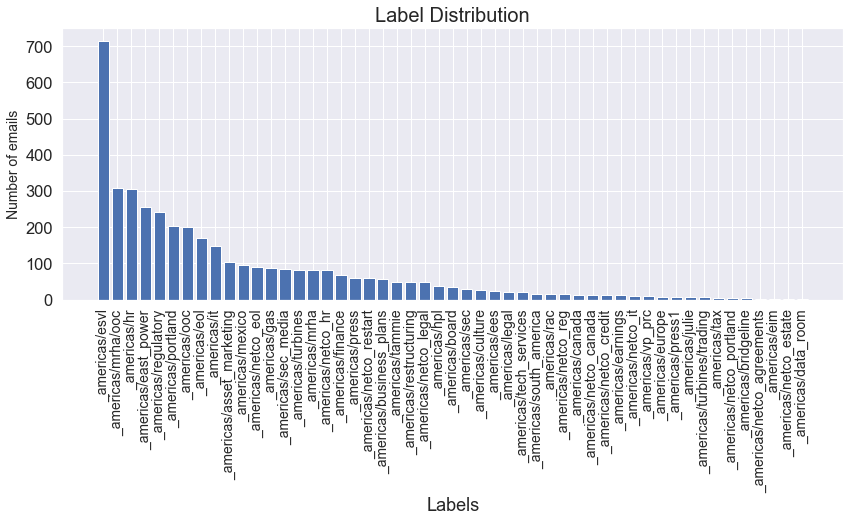

In [791]:
# Number of samples per class: ---- imbalanced dataset
count_map = Counter(kitchen_l_email['Folder'])
count_df = pd.DataFrame({'folders':list(count_map.keys()),'counts':list(count_map.values())})
count_df = count_df.sort_values(by='counts', ascending=False)
count_df['labels'] = np.arange(num_labels)
plt.figure(figsize=(14,5))
plt.bar(count_df.folders, count_df.counts, width=0.8)
plt.xlabel('Labels')
plt.ylabel('Number of emails', fontsize=14)
plt.title('Label Distribution', fontsize=20)
plt.xticks(
    rotation=90,
    fontsize=14,
)
plt.show()

In [1228]:
# Combine Labels in which sample size smaller than 60
min_sample_number = 60
count_df['combined_labels'] = count_df['labels']
max_label = len(count_df[count_df['counts']>=min_sample_number])
print('Number of labels to be assigned:', max_label+1)
count_df.loc[count_df['counts']<min_sample_number, 'combined_labels']='other'
count_df

Number of labels to be assigned: 21


folders  counts  labels combined_labels
12              _americas/esvl     715       0               0
23          _americas/mrha/ooc     309       1               1
17                _americas/hr     306       2               2
8         _americas/east_power     257       3               3
40        _americas/regulatory     242       4               4
36          _americas/portland     203       5               5
35               _americas/ooc     202       6               6
11               _americas/eol     171       7               7
18                _americas/it     149       8               8
0    _americas/asset_marketing     103       9               9
21            _americas/mexico      96      10              10
27         _americas/netco_eol      91      11              11
15               _americas/gas      87      12              12
42         _americas/sec_media      84      13              13
48          _americas/turbines      83      14              14
22              _americas/mrha      82      15              15
29          _americas/netco_hr      82      16              16
14           _americas/finance      68      17              17
37             _americas/press      61      18              18
34     _americas/netco_restart      61      19              19
3     _americas/business_plans      58      20           other
45            _americas/tammie      50      21           other
41     _americas/restructuring      49      22           other
31       _americas/netco_legal      48      23           other
16               _americas/hpl      37      24           other
1              _americas/board      34      25           other
43               _americas/sec      30      26           other
5            _americas/culture      27      27           other
9                _americas/ees      25      28           other
20             _americas/legal      21      29           other
47     _americas/tech_services      21      30           other
44     _americas/south_america      17      31           other
39               _americas/rac      16      32           other
33         _americas/netco_reg      16      33           other
4             _americas/canada      13      34           other
25      _americas/netco_canada      12      35           other
26      _americas/netco_credit      12      36           other
7           _americas/earnings      12      37           other
30          _americas/netco_it      11      38           other
50            _americas/vp_prc       9      39           other
13            _americas/europe       8      40           other
38            _americas/press1       7      41           other
19             _americas/julie       7      42           other
49  _americas/turbines/trading       7      43           other
46               _americas/tax       6      44           other
32    _americas/netco_portland       5      45           other
2         _americas/bridgeline       5      46           other
24  _americas/netco_agreements       2      47           other
10               _americas/eim       2      48           other
28      _americas/netco_estate       1      49           other
6          _americas/data_room       1      50           other

In [99]:
# Number of words per sample
def get_num_words_per_sample(sample_texts):
    """Returns the max, mean, median, min number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, (max, median, mean, min) number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.max(num_words), np.mean(num_words), np.median(num_words), np.min(num_words)

In [755]:
num_words_Multi_Fields = get_num_words_per_sample(kitchen_l_email['Multi-Fields'])
print(num_words_Multi_Fields)

(43948, 533.6774434220343, 142.0, 3)


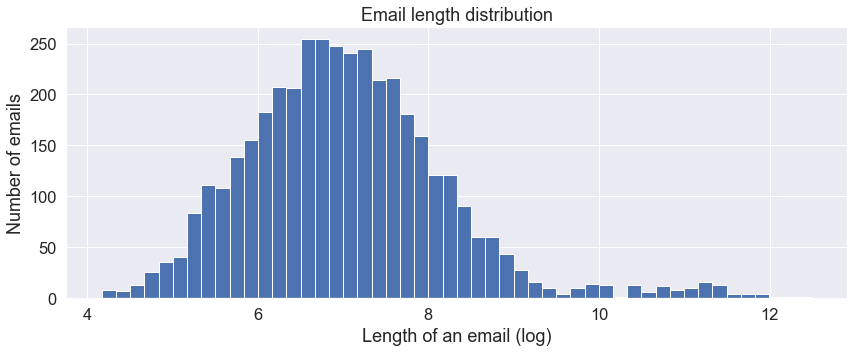

In [723]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.figure(figsize=(14,5))
    plt.hist([np.log(len(s)) for s in sample_texts], 50)
    plt.xlabel('Length of an email (log)')
    plt.ylabel('Number of emails')
    plt.title('Email length distribution')
    plt.show()

plot_sample_length_distribution(kitchen_l_email['Multi-Fields'])

In [722]:
# Calculate the number of samples/number of words per sample ratio.
num_samples/num_words_Multi_Fields[2]

28.316901408450704

# 3. Data Preprocessing

In [1271]:
with open('./Saveddata/kitchen_l.pickle', 'rb') as pickle_file:
    kitchen_l_email = pickle.load(pickle_file)

In [1272]:
# Add the colomn 'Multi-Fields'
temp = []
for i in range(len(kitchen_l_email)):
    temp.append(kitchen_l_email.Subject.iloc[i]+' '+' '.join(kitchen_l_email['Related Parties'].iloc[i])+' '+kitchen_l_email.Body.iloc[i])
kitchen_l_email['Multi-Fields'] = temp

# Add the colomn 'Labels'
kitchen_l_email['Labels'] = 0 # assign all labels to 0
for i in range(1,len(count_df['labels'])):
    kitchen_l_email.loc[kitchen_l_email['Folder']==count_df.iloc[i]['folders'],'Labels'] = i

# Add the colomn 'Combined Labels'
kitchen_l_email['Combined Labels'] = kitchen_l_email['Labels'] 
kitchen_l_email.loc[kitchen_l_email['Labels']>=max_label,'Combined Labels'] = 'other'

kitchen_l_email.sample(10)

file  \
256879     kitchen-l/_americas/east_power/246.   
256826     kitchen-l/_americas/east_power/199.   
258714            kitchen-l/_americas/mrha/54.   
260205       kitchen-l/_americas/sec_media/35.   
259088       kitchen-l/_americas/netco_eol/15.   
257630           kitchen-l/_americas/esvl/517.   
256959      kitchen-l/_americas/east_power/87.   
256658  kitchen-l/_americas/business_plans/58.   
260019     kitchen-l/_americas/regulatory/219.   
259985     kitchen-l/_americas/regulatory/189.   

                                                  message  \
256879  Message-ID: <21943975.1075840820894.JavaMail.e...   
256826  Message-ID: <6936254.1075840819630.JavaMail.ev...   
258714  Message-ID: <10003955.1075840867980.JavaMail.e...   
260205  Message-ID: <31669165.1075840926182.JavaMail.e...   
259088  Message-ID: <28380400.1075840879119.JavaMail.e...   
257630  Message-ID: <11196208.1075840841608.JavaMail.e...   
256959  Message-ID: <26740186.1075840816674.JavaMail.e...   
256658  Message-ID: <12218612.1075840812663.JavaMail.e...   
260019  Message-ID: <12344036.1075840903635.JavaMail.e...   
259985  Message-ID: <23058853.1075840902287.JavaMail.e...   

                            Date                        From  \
256879 2001-03-16 14:10:00-08:00   [drew.tingleaf@enron.com]   
256826 2001-04-26 19:37:00-07:00   [drew.tingleaf@enron.com]   
258714 2001-06-22 21:43:00-07:00       [jean.mrha@enron.com]   
260205 2001-11-13 14:53:13-08:00  [courtney.votaw@enron.com]   
259088 2002-02-01 12:53:10-08:00   [david.forster@enron.com]   
257630 2001-11-16 12:22:08-08:00         [kenny.foo@ngx.com]   
256959 2001-09-12 09:33:28-07:00   [heather.kroll@enron.com]   
256658 2001-02-15 15:46:00-08:00  [david.delainey@enron.com]   
260019 2001-03-15 13:13:00-08:00     [marty.sunde@enron.com]   
259985 2001-04-23 17:07:00-07:00   [kristin.walsh@enron.com]   

                                         Subject  \
256879                              Markus Fiala   
256826                                             
258714                                 FW: PLUTO   
260205                            Enron Mentions   
259088                    Priority Customer List   
257630                           Lavorato family   
256959                RE: NC Power Holdings deal   
256658                       2001 Central Region   
260019  Summary of Enron's filing in UC/CSU case   
259985                 California Update 4/23/01   

                                                 X-Folder   Employee  \
256879    \ExMerge - Kitchen, Louise\'Americas\East Power  kitchen-l   
256826    \ExMerge - Kitchen, Louise\'Americas\East Power  kitchen-l   
258714          \ExMerge - Kitchen, Louise\'Americas\Mrha  kitchen-l   
260205     \ExMerge - Kitchen, Louise\'Americas\SEC media  kitchen-l   
259088     \ExMerge - Kitchen, Louise\'Americas\Netco EOL  kitchen-l   
257630          \ExMerge - Kitchen, Louise\'Americas\ESVL  kitchen-l   
256959    \ExMerge - Kitchen, Louise\'Americas\East Power  kitchen-l   
256658  \ExMerge - Kitchen, Louise\'Americas\Business ...  kitchen-l   
260019    \ExMerge - Kitchen, Louise\'Americas\Regulatory  kitchen-l   
259985    \ExMerge - Kitchen, Louise\'Americas\Regulatory  kitchen-l   

                          Folder Email Number  \
256879      _americas/east_power         246.   
256826      _americas/east_power         199.   
258714            _americas/mrha          54.   
260205       _americas/sec_media          35.   
259088       _americas/netco_eol          15.   
257630            _americas/esvl         517.   
256959      _americas/east_power          87.   
256658  _americas/business_plans          58.   
260019      _americas/regulatory         219.   
259985      _americas/regulatory         189.   

                                                     Body  \
256879  Louise:  I followed up with Markus.  He reques...   
256826  Team:  We had a very productive meeting with A...   
258714  FYI.. this is to 

In [1232]:
np.random.seed(400)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/ll/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [1273]:
# Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
# Stopwords removal: All stopwords are removed.
# Lemmatization: words in third person are changed to first person and verbs in past and future tenses are changed into present.
# Stemming: words are reduced to their root form.

stemmer = SnowballStemmer("english")
def preprocess(text):
    result=""
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in ['enron','com']:# and len(token) > 3:
            result += ' '+stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v'))
    return result.strip()

text_sample = kitchen_l_email['Multi-Fields'].iloc[0]
print("Original document: ")
print(text_sample)
print("\n\nPreprocessed document: ")
print(preprocess(text_sample))

Original document: 
Asset Marketing/Corporate Development jeff.donahue@enron.com louise.kitchen@enron.com no.address@enron.com Jeff,  As we discussed, attached is a comprehensive list of the team and deals. As you know, Louise formally calls our team Asset Marketing. I tend to think that we play a number of roles including corporate development, CTG, deal structuring, and anything else that is required to get a deal done.   In addition to the core team, I believe we also need to consider other issues related to asset sales including DealBench ("DB").  DB is a tremendous platform, that should be maintained.  It facilitates the sales process in so many ways, and would require very little to keep it alive.  Jon Hoff in our group can do almost anything related to DB and would probably require one engineer (not 100% of his time) to be available for DB to maintained.    In addition to our team, the development group run by Ben Jacoby has been selling development sites, and Chris Calger has a

In [1274]:
kitchen_l_email['Multi-Fields Processed'] = kitchen_l_email['Multi-Fields'].map(preprocess)
kitchen_l_email.sample(5)

file  \
257127        kitchen-l/_americas/eol/48.   
259850      kitchen-l/_americas/press/53.   
259138  kitchen-l/_americas/netco_eol/60.   
259738   kitchen-l/_americas/portland/41.   
259710    kitchen-l/_americas/portland/2.   

                                                  message  \
257127  Message-ID: <14697163.1075840823258.JavaMail.e...   
259850  Message-ID: <16117102.1075840893717.JavaMail.e...   
259138  Message-ID: <29870864.1075840880212.JavaMail.e...   
259738  Message-ID: <8207430.1075840887787.JavaMail.ev...   
259710  Message-ID: <903025.1075840886771.JavaMail.eva...   

                            Date                        From  \
257127 2001-11-19 15:30:35-08:00  [lindsay.renaud@enron.com]   
259850 2001-06-07 10:16:00-07:00  [enron.cuttings@enron.com]   
259138 2002-01-17 11:02:04-08:00        [kal.shah@enron.com]   
259738 2001-08-29 08:06:54-07:00      [tim.belden@enron.com]   
259710 2001-12-21 11:41:42-08:00       [f..calger@enron.com]   

                                             Subject  \
257127  Trade Count and Volume for November 19, 2001   
259850     California power crisis...(Enron mention)   
259138    FW: Home page Mockup with different colors   
259738                             Upcoming Vacation   
259710                            West Power Prepays   

                                              X-Folder   Employee  \
257127        \ExMerge - Kitchen, Louise\'Americas\EOL  kitchen-l   
259850      \ExMerge - Kitchen, Louise\'Americas\Press  kitchen-l   
259138  \ExMerge - Kitchen, Louise\'Americas\Netco EOL  kitchen-l   
259738   \ExMerge - Kitchen, Louise\'Americas\Portland  kitchen-l   
259710   \ExMerge - Kitchen, Louise\'Americas\Portland  kitchen-l   

                     Folder Email Number  \
257127        _americas/eol          48.   
259850      _americas/press          53.   
259138  _americas/netco_eol          60.   
259738   _americas/portland          41.   
259710   _americas/portland           2.   

                                                     Body  \
257127  Lindsay  Lindsay Renaud EnronOnline (713) 345-...   
259850  Please find attached the following article/s: ...   
259138  Some more options we can discuss in the meetin...   
259738  I am planning on taking vacation from Septembe...   
259710  Attached please find a spreadsheet that descri...   

                                          Related Parties  \
257127  [a..shankman@enron.com, adam.johnson@enron.com...   
259850  [alex.parsons@enron.com, andrew.morrison@enron...   
259138     [kal.shah@enron.com, louise.kitchen@enron.com]   
259738  [john.lavorato@enron.com, louise.kitchen@enron...   
259710  [david.gorte@enron.com, elizabeth.sager@enron....   

                                             Multi-Fields  Labels  \
257127  Trade Count and Volume for November 19, 2001 a...       7   
259850  California power crisis...(Enron mention) alex...      18   
259138  FW: Home page Mockup with different colors kal...      11   
259738  Upcoming Vacation john.lavorato@enron.com loui...       5   
259710  West Power Prepays david.gorte@enron.com eliza...       5   

       Combined Labels                             Multi-Fields Processed  
257127               7  trade count volum novemb shankman adam johnson...  
259850              18  california power crisi mention alex parson and...  
259138              11  fw home page mockup differ color kal shah loui...  
259738               5  upcom vacat john lavorato louis kitchen tim be...  
259710               5  west power prepay david gort elizabeth sager c...

In [1276]:
kitchen_l_email.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4021 entries, 256463 to 260483
Data columns (total 15 columns):
file                      4021 non-null object
message                   4021 non-null object
Date                      4021 non-null datetime64[ns, tzlocal()]
From                      4021 non-null object
Subject                   4021 non-null object
X-Folder                  4021 non-null object
Employee                  4021 non-null object
Folder                    4021 non-null object
Email Number              4021 non-null object
Body                      4021 non-null object
Related Parties           4021 non-null object
Multi-Fields              4021 non-null object
Labels                    4021 non-null int64
Combined Labels           4021 non-null object
Multi-Fields Processed    4021 non-null object
dtypes: datetime64[ns, tzlocal()](1), int64(1), object(13)
memory usage: 502.6+ KB


In [1277]:
kl_email = kitchen_l_email[['Date', 'Folder', 'Multi-Fields Processed', 'Labels', 'Combined Labels']]
kl_email = kl_email.sort_values(by='Date')

In [1278]:
kl_email = pd.concat([kl_email, pd.get_dummies(kl_email['Combined Labels'])], axis=1)
kl_email.head(3)

Date                Folder  \
258316 2001-02-07 19:39:00-08:00          _americas/hr   
256990 2001-02-07 20:06:00-08:00         _americas/ees   
260045 2001-02-08 12:21:00-08:00  _americas/regulatory   

                                   Multi-Fields Processed  Labels  \
258316  key hr issu go forward david delainey david ox...       2   
256990  congrat berney aucoin daniel allegretti david ...      28   
260045  california power gari hickerson heizenrad home...       4   

       Combined Labels  0  1  2  3  4  ...  11  12  13  14  15  16  17  18  \
258316               2  0  0  1  0  0  ...   0   0   0   0   0   0   0   0   
256990           other  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
260045               4  0  0  0  0  1  ...   0   0   0   0   0   0   0   0   

        19  other  
258316   0      0  
256990   0      1  
260045   0      0  

[3 rows x 26 columns]

In [1279]:
com_counts = kl_email['Combined Labels'].value_counts()
com_counts.keys(), com_counts.values

(Index([0, 'other', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
        19, 18],
       dtype='object'),
 array([715, 569, 309, 306, 257, 242, 203, 202, 171, 149, 103,  96,  91,
         87,  84,  83,  82,  82,  68,  61,  61]))

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

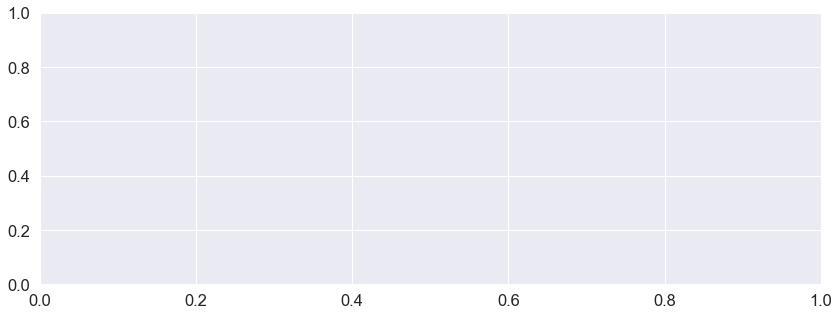

In [1255]:
plt.figure(figsize=(14,5))
plt.bar(np.array(com_counts.keys()), com_counts.values)#, width=0.8)
plt.xlabel('Combined Labels')
plt.ylabel('Number of emails', fontsize=14)
plt.title('Label Distribution', fontsize=20)
plt.xticks(
    rotation=90,
    fontsize=14,
)
plt.show()

In [1280]:
# Change labels for multi-label emails to [1,0,1,0,...]
same_content = kl_email['Multi-Fields Processed'].value_counts()
mullabel_email = same_content[same_content.values>1]
mullabel_email.values

array([5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [1281]:
keys_mullabel = mullabel_email.keys()
len(keys_mullabel)

238

In [1290]:
for i in keys_mullabel:
    temp = kl_email[kl_email['Multi-Fields Processed']==i]
    if len(temp['Combined Labels'].unique())>1:
        kl_email.loc[temp.index[0],temp['Combined Labels']] = 1
        kl_email.loc[temp.index[0],'Combined Labels'] = str(temp['Combined Labels'].tolist())        
        kl_email.drop(temp.index[1:], axis = 0, inplace = True)

In [1294]:
i = keys_mullabel[90]
temp = kl_email[kl_email['Multi-Fields Processed']==i]
print(temp)

                            Date         Folder  \
259415 2001-09-07 08:58:04-07:00  _americas/ooc   

                                   Multi-Fields Processed  Labels  \
259415  lv pastoria updat cris sherman louis kitchen o...       6   

       Combined Labels  0  1  2  3  4  ...  11  12  13  14  15  16  17  18  \
259415          [6, 1]  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   

        19  other  
259415   0      0  

[1 rows x 26 columns]


In [1298]:
 kl_email[count_df['combined_labels'].unique()].sum()

0        715
1        309
2        306
3        257
4        242
5        203
6        202
7        171
8        149
9        103
10        96
11        91
12        87
13        84
14        83
15        82
16        82
17        68
18        61
19        61
other    569
dtype: int64

# 4. Classification

In [1360]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            #'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
            'stop_words': 'english',
            'max_df':1.0,
            'min_df': 1
        
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)
    #print(vectorizer.get_feature_names()[0:50])
    #print("stop_words_:",vectorizer.stop_words_)
    #print("vocabulary length:", len(vectorizer.vocabulary_))

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [1303]:
t1, t2=ngram_vectorize((X_train), (y_train), (X_test))

In [1304]:
print(t1.shape,t2.shape)

(2648, 306745) (1136, 306745)


In [1305]:
print(t1[0,:])

  (0, 227623)	0.1159822216844342
  (0, 283907)	0.14290470870328484
  (0, 189720)	0.14290470870328484
  (0, 190713)	0.14290470870328484
  (0, 140677)	0.14290470870328484
  (0, 283996)	0.13017827194605722
  (0, 128215)	0.13352576267687596
  (0, 143586)	0.14290470870328484
  (0, 89099)	0.14290470870328484
  (0, 140468)	0.13017827194605722
  (0, 184375)	0.14290470870328484
  (0, 115255)	0.14290470870328484
  (0, 204563)	0.13352576267687596
  (0, 302594)	0.12273378367527973
  (0, 143792)	0.14290470870328484
  (0, 68432)	0.26705152535375193
  (0, 53134)	0.14290470870328484
  (0, 235852)	0.13352576267687596
  (0, 201314)	0.11216988670237953
  (0, 289141)	0.13762276021683473
  (0, 34518)	0.08262001564796552
  (0, 79654)	0.14290470870328484
  (0, 304817)	0.13762276021683473
  (0, 173012)	0.10125084582898528
  (0, 155483)	0.14290470870328484
  :	:
  (0, 33711)	0.04983776625985077
  (0, 79621)	0.06752816005654885
  (0, 172927)	0.07095653359305276
  (0, 155061)	0.0439873399420495
  (0, 115060)	0.1

In [1386]:
X = kl_email['Multi-Fields Processed'] 
ylabels = kl_email[count_df['combined_labels'].unique()] 

In [1441]:
# Model Accuracy
def plot_evaluation(y_test, predicted):
    #print("Accuracy:",metrics.accuracy_score(y_test, predicted))
    #print("Precision:",metrics.precision_score(y_test, predicted))
    #print("Recall:",metrics.recall_score(y_test, predicted))
    #print("F1:",metrics.f1_score(y_test, predicted))
    class_report = classification_report(y_test, predicted, output_dict=True)
    print(class_report)
    labels=["Other", "Target"]
    confusion = confusion_matrix(y_test,predicted)
    sns.set(font_scale=1.5)    
    plt.figure(figsize=(8,5))
    ax = sns.heatmap(confusion, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Classes', fontsize = 20)
    plt.ylabel('True Classes', fontsize = 20)
    plt.tick_params(labelsize = 15)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    # Show classification report
    #plt.figure(figsize=(10,7))
    #class_report = classification_report(actual_labels, predicted_labels, target_names=labels, output_dict=True)# .iloc[:-1, :] to exclude support
    #sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, cmap = "Blues", annot=True)
    #plt.title("Classification Report", fontsize = 30)
    return confusion, class_report

In [ ]:
def plot_histrory(history):
    # Summarize history for accuracy
    plt.figure(figsize=[10,6])
    plt.plot(history['acc'], label='Training accuracy')
    plt.plot(history['val_acc'], label='Validation accuracy')
    plt.title('Training and validation accuracy', fontsize = 20)
    plt.ylabel('accuracy', fontsize = 15)
    plt.xlabel('epoch', fontsize = 15)
    plt.legend(loc='upper left', fontsize = 15)
    plt.show()

    # Summarize history for loss
    plt.figure(figsize=[10,6])
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and validation loss', fontsize = 20)
    plt.ylabel('loss', fontsize = 15)
    plt.xlabel('epoch', fontsize = 15)
    plt.legend(loc='upper right', fontsize = 15)
    plt.show()

# Logistic Regression

**Processing Label 0 ...**
Accuracy: 0.8274647887323944
Precision: 0.7714285714285715
Recall: 0.12558139534883722
F1: 0.21600000000000003


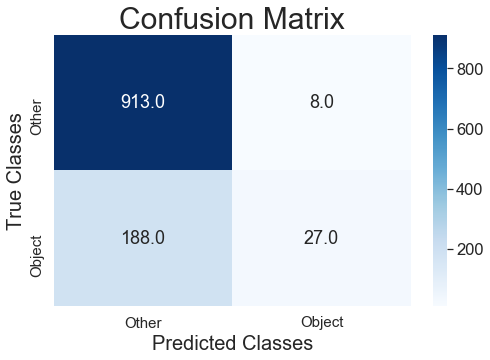

**Processing Label 1 ...**
Accuracy: 0.9198943661971831
Precision: 1.0
Recall: 0.021505376344086023
F1: 0.04210526315789474


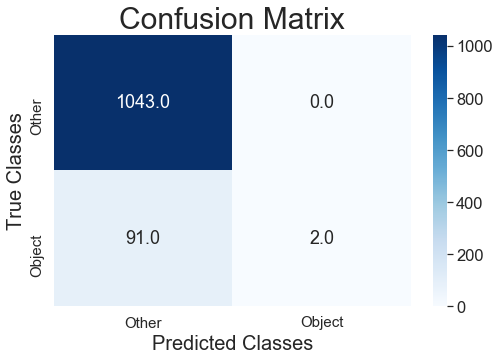

**Processing Label 2 ...**
Accuracy: 0.920774647887324
Precision: 1.0
Recall: 0.021739130434782608
F1: 0.042553191489361694


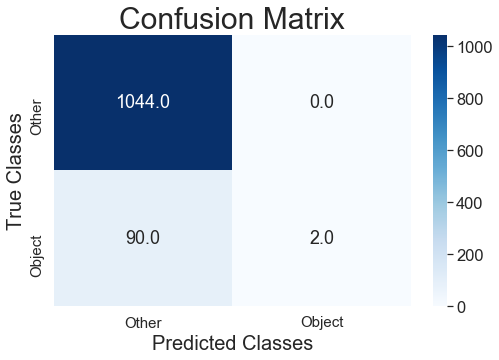

**Processing Label 3 ...**
Accuracy: 0.9427816901408451
Precision: 1.0
Recall: 0.15584415584415584
F1: 0.2696629213483146


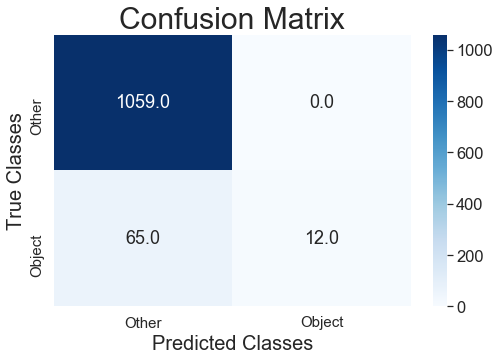

**Processing Label 4 ...**
Accuracy: 0.9691901408450704
Precision: 0.9523809523809523
Recall: 0.547945205479452
F1: 0.6956521739130435


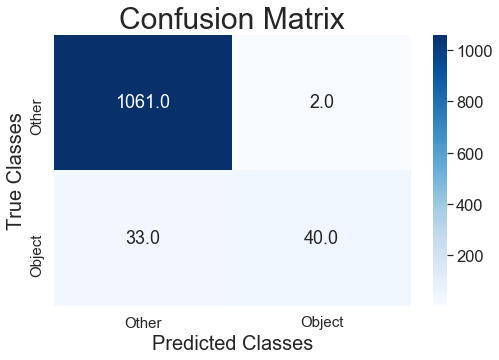

**Processing Label 5 ...**
Accuracy: 0.9471830985915493
Precision: 1.0
Recall: 0.01639344262295082
F1: 0.03225806451612903


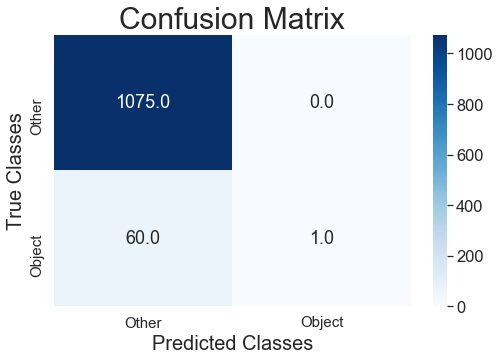

**Processing Label 6 ...**
Accuracy: 0.9463028169014085
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


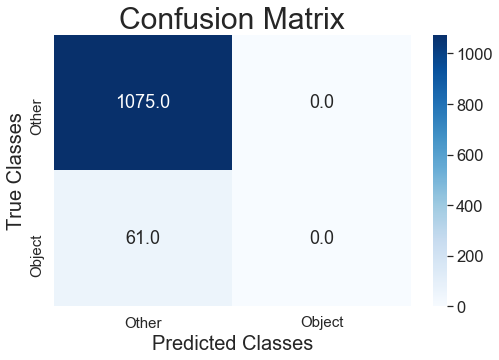

**Processing Label 7 ...**
Accuracy: 0.960387323943662
Precision: 0.875
Recall: 0.13725490196078433
F1: 0.23728813559322037


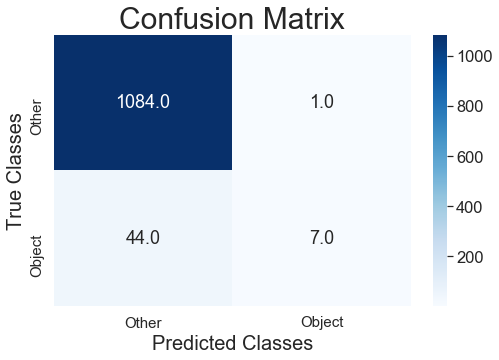

**Processing Label 8 ...**
Accuracy: 0.9709507042253521
Precision: 1.0
Recall: 0.26666666666666666
F1: 0.4210526315789474


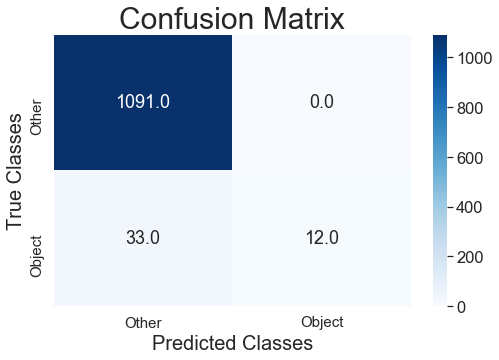

**Processing Label 9 ...**
Accuracy: 0.9727112676056338
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


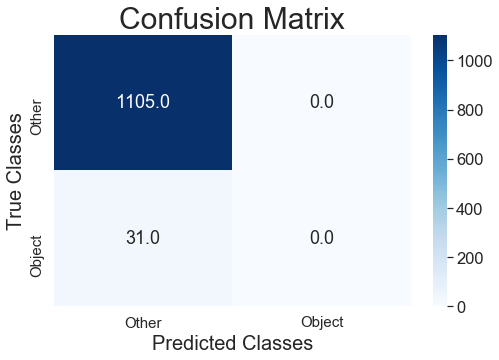

**Processing Label 10 ...**
Accuracy: 0.9744718309859155
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


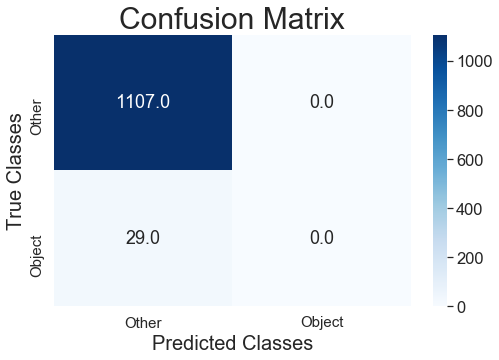

**Processing Label 11 ...**
Accuracy: 0.9762323943661971
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


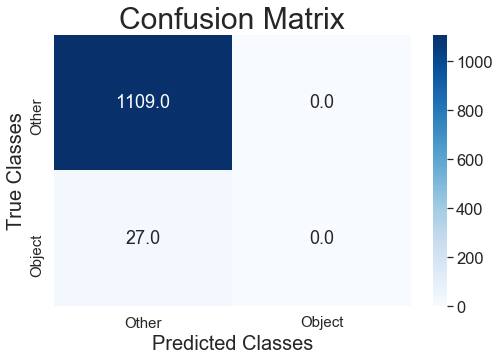

**Processing Label 12 ...**
Accuracy: 0.977112676056338
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


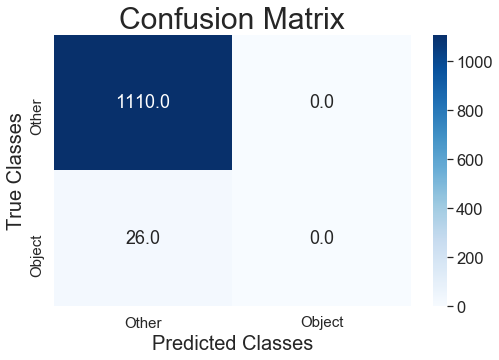

**Processing Label 13 ...**
Accuracy: 0.9955985915492958
Precision: 1.0
Recall: 0.8
F1: 0.888888888888889


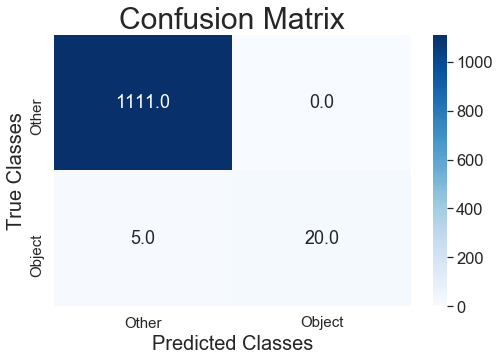

**Processing Label 14 ...**
Accuracy: 0.9788732394366197
Precision: 1.0
Recall: 0.04
F1: 0.07692307692307693


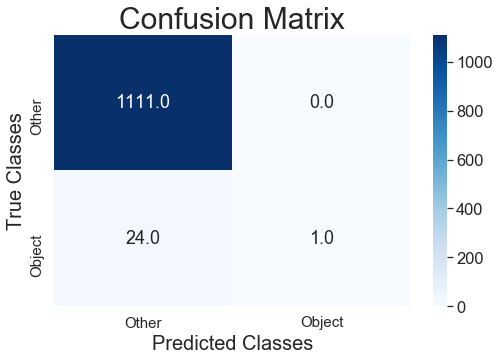

**Processing Label 15 ...**
Accuracy: 0.9779929577464789
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


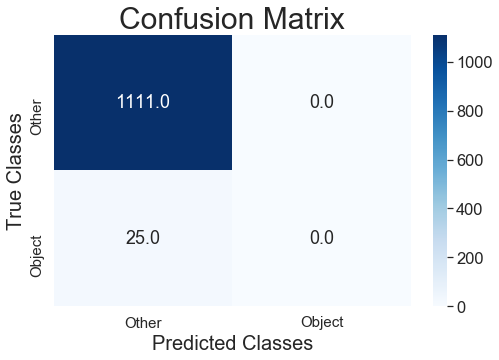

**Processing Label 16 ...**
Accuracy: 0.9779929577464789
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


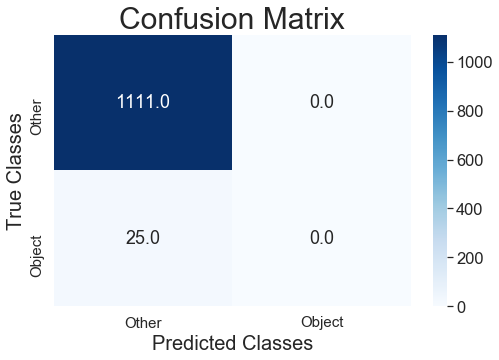

**Processing Label 17 ...**
Accuracy: 0.9823943661971831
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


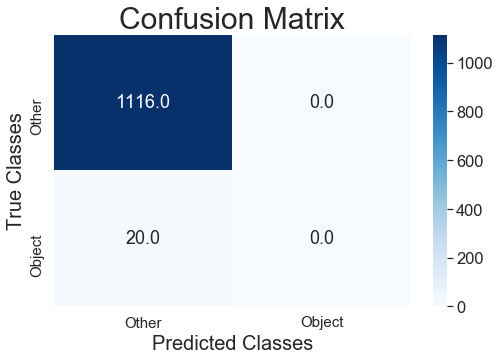

**Processing Label 18 ...**
Accuracy: 0.9876760563380281
Precision: 1.0
Recall: 0.2222222222222222
F1: 0.3636363636363636


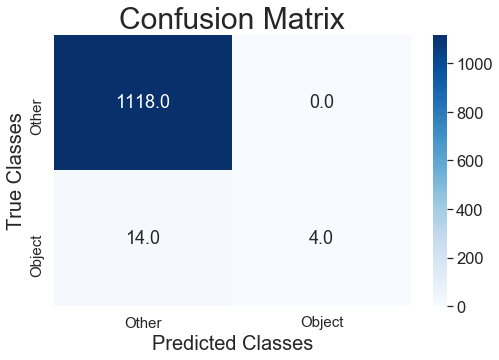

**Processing Label 19 ...**
Accuracy: 0.9841549295774648
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


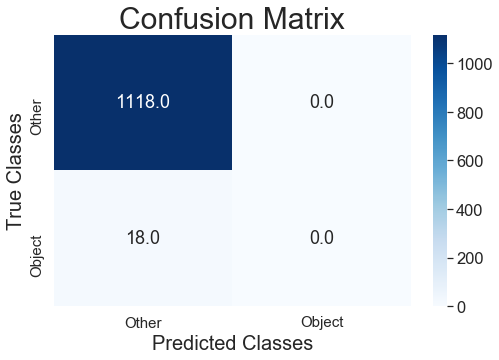

**Processing Label other ...**
Accuracy: 0.8644366197183099
Precision: 0.9047619047619048
Recall: 0.1111111111111111
F1: 0.19791666666666666


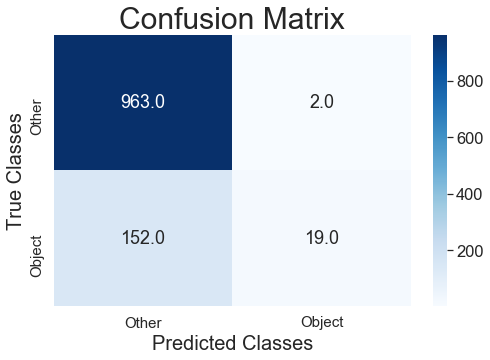

In [1376]:
# Using pipeline for applying logistic regression and one vs rest classifier

labels = count_df['combined_labels'].unique()
    
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for label in labels:
    print('**Processing Label {} ...**'.format(label))
    X_train, X_test, y_train, y_test = train_test_split(X, ylabels[label], test_size=0.3, random_state=0, stratify=ylabels[label])#, shuffle=False)      
    print(X_train_vec.shape,y_train.shape,X_test_vec.shape,y_test.shape)
    X_train_vec, X_test_vec = ngram_vectorize((X_train), (y_train), (X_test))
  
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train_vec, y_train)
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test_vec)
    #print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    #print("\n")
    plot_evaluation(y_test, prediction)

# Multilayer perceptron (MLP)

In [1385]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of Dense layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    
    if num_classes == 2:
        last_units = 1
    else:
        last_units = num_classes
    model.add(Dense(units=last_units, activation='sigmoid'))
    #model.summary()
    return model


In [1448]:
def train_ngram_model(data,num_classes,target_label,
                      learning_rate=1e-2,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=32,
                      dropout_rate=0.3):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
    """
    # Get the data.
    (x_train, y_train), (x_test, y_test) = data
    
    # Create model instance.
    model = mlp_model(layers=layers,
                      units=units,
                      dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:],
                      num_classes=num_classes)

    # Compile model with learning parameters.    
    loss = 'binary_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    model.summary() 
    
    # Save model.
    checkpointer = ModelCheckpoint(filepath=save_model_folder + "BestModel_Label_{target_label}" + ".h5",     
                                   monitor='val_acc', verbose=1, save_best_only=True)
    # Early Stopping
    earlystopper = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
    
    # Train and validate model.
    history = model.fit(
            x_train,
            y_train,
            epochs=epochs,
            callbacks = [checkpointer,earlystopper],
            validation_data=(x_test, y_test),
            verbose=2,  
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    plot_histrory(history)
    
    # Save history
    with open(save_model_folder+'trainHistory_Label_{target_label}', 'wb') as pickle_file:
        pickle.dump(history, pickle_file)
        
    # Evaluation
    best_model_path = './SavedModel/BestModel_Label_{target_label}.h5'
    best_model = tf.keras.models.load_model(best_model_path)
    predicted = best_model.predict(x_test)
    predicted_c = (predicted>0.5)
    confusion,class_report = plot_evaluation(y_test, predicted_c)
    # Save results to file
    f_myfile = open('kitchen_l_result.pickle', 'wb')
    pickle.dump([confusion, class_report,  predicted, y_test_a], f_myfile)
    f_myfile.close()
    return confusion, class_report, best_model, predicted

**Processing Label 0 ...**
(1000, 20000) (1000,)
500 215
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_79 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_79 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_80 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_81 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
_____________

Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.89877
 - 2s - loss: 0.0203 - acc: 0.9930 - val_loss: 0.6917 - val_acc: 0.8732
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.89877
 - 2s - loss: 0.0229 - acc: 0.9940 - val_loss: 0.6870 - val_acc: 0.8873
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.89877
 - 2s - loss: 0.0312 - acc: 0.9890 - val_loss: 0.6591 - val_acc: 0.8864
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.89877
 - 2s - loss: 0.0207 - acc: 0.9910 - val_loss: 0.6427 - val_acc: 0.8803
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.89877
 - 2s - loss: 0.0200 - acc: 0.9920 - val_loss: 0.6475 - val_acc: 0.8882
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.89877
 - 1s - loss: 0.0255 - acc: 0.9930 - val_loss: 0.6526 - val_acc: 0.8794
Epoch 00055: early stopping
Validation accuracy: 0.8794013857841492, loss: 0.6526340153855337


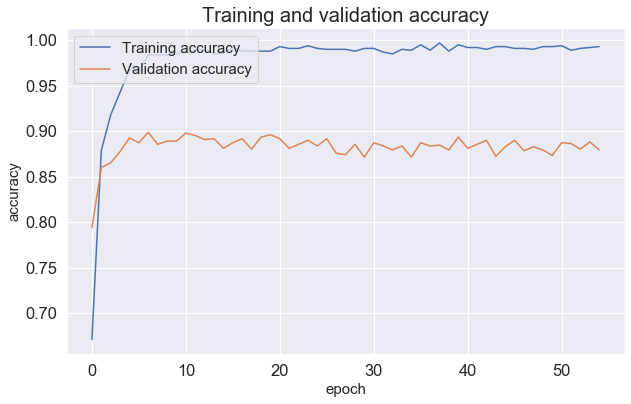

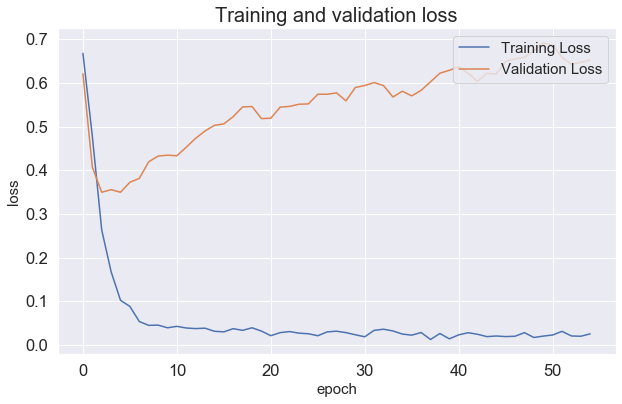

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       921
           1       0.75      0.71      0.73       215

    accuracy                           0.90      1136
   macro avg       0.84      0.83      0.83      1136
weighted avg       0.90      0.90      0.90      1136



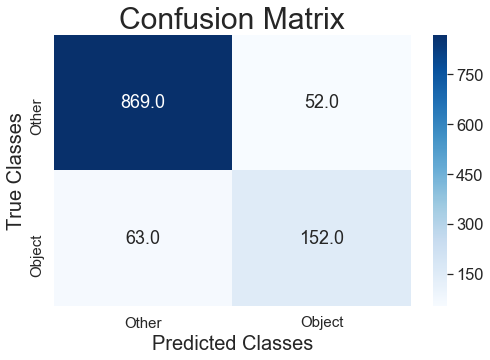

**Processing Label 1 ...**
(432, 20000) (432,)
216 93
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_82 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_82 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_83 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_84 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.93310
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.5534 - val_acc: 0.9269
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.93310
 - 1s - loss: 6.3332e-04 - acc: 1.0000 - val_loss: 0.5541 - val_acc: 0.9269
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.93310
 - 1s - loss: 9.7578e-04 - acc: 1.0000 - val_loss: 0.5570 - val_acc: 0.9287
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.93310
 - 1s - loss: 4.9916e-04 - acc: 1.0000 - val_loss: 0.5608 - val_acc: 0.9305
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.93310
 - 1s - loss: 4.8734e-04 - acc: 1.0000 - val_loss: 0.5638 - val_acc: 0.9305
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.93310
 - 1s - loss: 9.5515e-04 - acc: 1.0000 - val_loss: 0.5660 - val_acc: 0.9313
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.93310
 - 1s - loss: 4.5618e-04 - acc: 1.0000 - val_loss: 0.5680 - val_acc: 0.9305
Epoch 56/1000

Ep

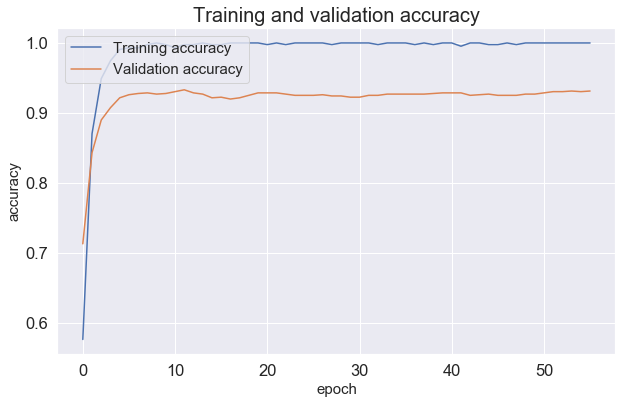

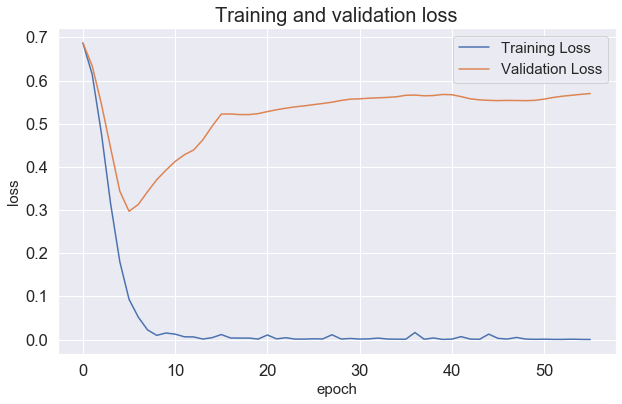

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1043
           1       0.61      0.49      0.55        93

    accuracy                           0.93      1136
   macro avg       0.78      0.73      0.76      1136
weighted avg       0.93      0.93      0.93      1136



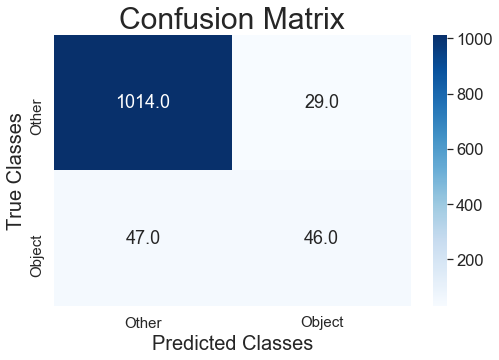

**Processing Label 2 ...**
(428, 20000) (428,)
214 92
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_85 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_85 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_86 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_87 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.95335
 - 1s - loss: 2.5476e-04 - acc: 1.0000 - val_loss: 0.3752 - val_acc: 0.9463
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.95335
 - 1s - loss: 0.0026 - acc: 0.9977 - val_loss: 0.3918 - val_acc: 0.9498
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.95335
 - 1s - loss: 0.0048 - acc: 0.9977 - val_loss: 0.4002 - val_acc: 0.9498
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.95335
 - 1s - loss: 1.3814e-04 - acc: 1.0000 - val_loss: 0.4048 - val_acc: 0.9498
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.95335
 - 1s - loss: 4.2037e-04 - acc: 1.0000 - val_loss: 0.4078 - val_acc: 0.9489
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.95335
 - 1s - loss: 1.4576e-04 - acc: 1.0000 - val_loss: 0.4125 - val_acc: 0.9498
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.95335
 - 1s - loss: 1.0013e-04 - acc: 1.0000 - val_loss: 0.4155 - val_acc: 0.9489
Epoch 00055: early st

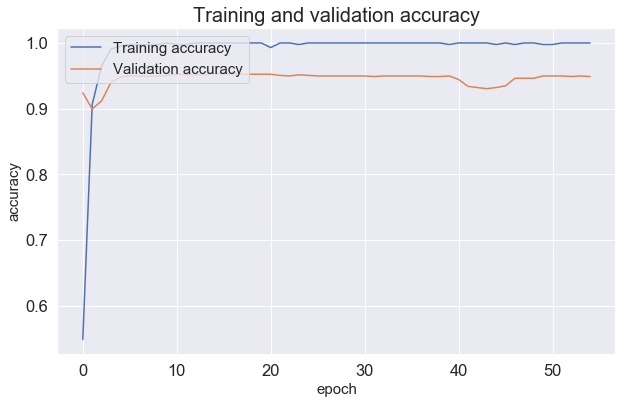

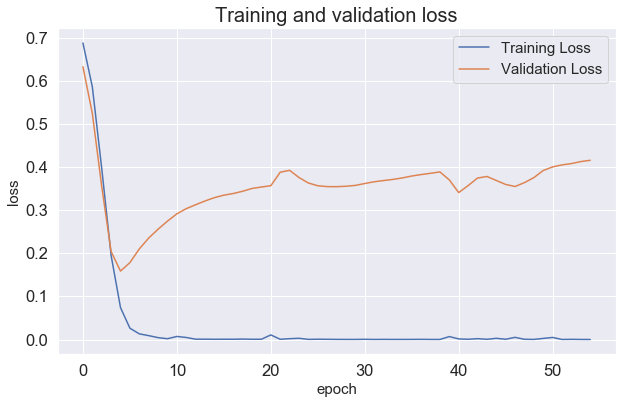

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1044
           1       0.81      0.55      0.66        92

    accuracy                           0.95      1136
   macro avg       0.89      0.77      0.82      1136
weighted avg       0.95      0.95      0.95      1136



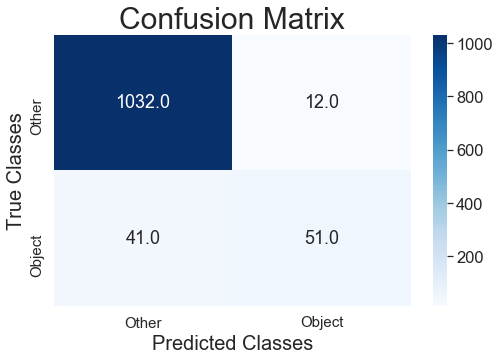

**Processing Label 3 ...**
(360, 20000) (360,)
180 77
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_88 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_88 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_89 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_90 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.96655
 - 1s - loss: 5.8230e-04 - acc: 1.0000 - val_loss: 0.2369 - val_acc: 0.9569
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.96655
 - 1s - loss: 1.2563e-04 - acc: 1.0000 - val_loss: 0.2425 - val_acc: 0.9569
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.96655
 - 1s - loss: 6.8721e-05 - acc: 1.0000 - val_loss: 0.2482 - val_acc: 0.9577
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.96655
 - 1s - loss: 1.1112e-04 - acc: 1.0000 - val_loss: 0.2526 - val_acc: 0.9577
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.96655
 - 1s - loss: 5.9219e-05 - acc: 1.0000 - val_loss: 0.2574 - val_acc: 0.9577
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.96655
 - 1s - loss: 4.0224e-05 - acc: 1.0000 - val_loss: 0.2609 - val_acc: 0.9586
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.96655
 - 1s - loss: 6.9648e-05 - acc: 1.0000 - val_loss: 0.2635 - val_acc: 0.9595
Epoch 55/1000

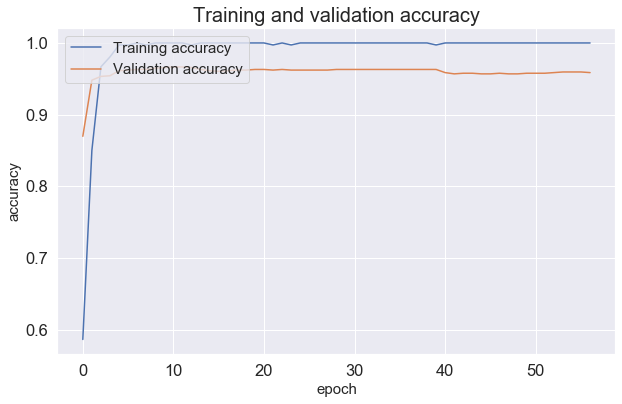

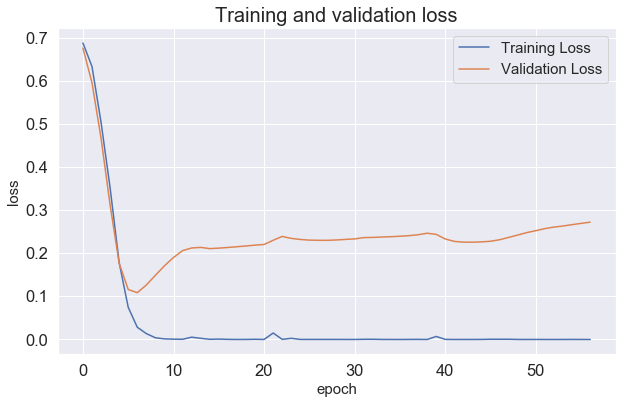

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1059
           1       0.90      0.57      0.70        77

    accuracy                           0.97      1136
   macro avg       0.93      0.78      0.84      1136
weighted avg       0.96      0.97      0.96      1136



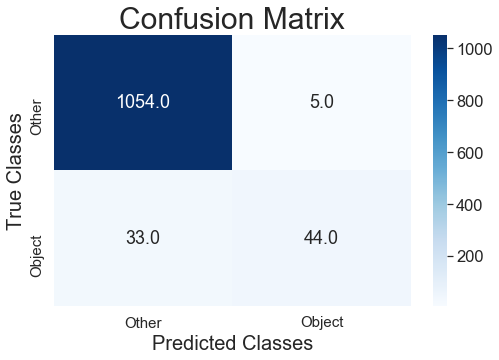

**Processing Label 4 ...**
(338, 20000) (338,)
169 73
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_91 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_91 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_92 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_93 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.98768
 - 1s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.1482 - val_acc: 0.9780
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.98768
 - 1s - loss: 0.0055 - acc: 0.9970 - val_loss: 0.1354 - val_acc: 0.9842
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.98768
 - 1s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1242 - val_acc: 0.9859
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.98768
 - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.1169 - val_acc: 0.9868
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.98768
 - 1s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1101 - val_acc: 0.9868
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.98768
 - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.1048 - val_acc: 0.9868
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.98768
 - 1s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.1019 - val_acc: 0.9877
Epoch 55/1000

Epoch 00055: val_acc did n

Epoch 107/1000

Epoch 00107: val_acc did not improve from 0.98856
 - 1s - loss: 4.9184e-04 - acc: 1.0000 - val_loss: 0.1184 - val_acc: 0.9877
Epoch 108/1000

Epoch 00108: val_acc did not improve from 0.98856
 - 1s - loss: 3.9912e-04 - acc: 1.0000 - val_loss: 0.1284 - val_acc: 0.9868
Epoch 109/1000

Epoch 00109: val_acc did not improve from 0.98856
 - 1s - loss: 4.4106e-04 - acc: 1.0000 - val_loss: 0.1358 - val_acc: 0.9868
Epoch 110/1000

Epoch 00110: val_acc did not improve from 0.98856
 - 1s - loss: 3.5181e-04 - acc: 1.0000 - val_loss: 0.1415 - val_acc: 0.9842
Epoch 111/1000

Epoch 00111: val_acc did not improve from 0.98856
 - 1s - loss: 4.3562e-04 - acc: 1.0000 - val_loss: 0.1459 - val_acc: 0.9842
Epoch 112/1000

Epoch 00112: val_acc did not improve from 0.98856
 - 1s - loss: 6.4763e-04 - acc: 1.0000 - val_loss: 0.1451 - val_acc: 0.9842
Epoch 113/1000

Epoch 00113: val_acc did not improve from 0.98856
 - 1s - loss: 2.7566e-04 - acc: 1.0000 - val_loss: 0.1439 - val_acc: 0.9842
Epoch 

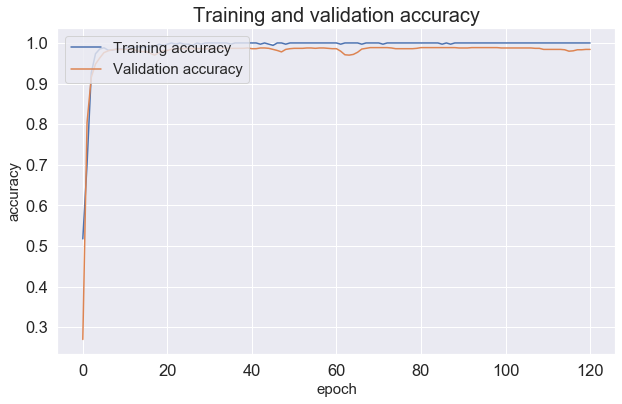

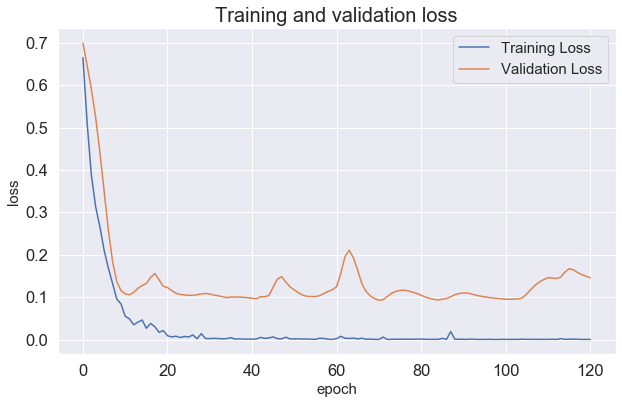

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1063
           1       0.86      0.99      0.92        73

    accuracy                           0.99      1136
   macro avg       0.93      0.99      0.96      1136
weighted avg       0.99      0.99      0.99      1136



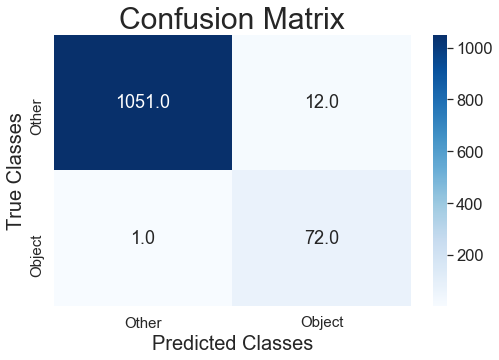

**Processing Label 5 ...**
(284, 20000) (284,)
142 61
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_94 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_94 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_95 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_96 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.96655
 - 0s - loss: 5.6275e-05 - acc: 1.0000 - val_loss: 0.2252 - val_acc: 0.9657
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.96655
 - 0s - loss: 3.4440e-04 - acc: 1.0000 - val_loss: 0.2259 - val_acc: 0.9657
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.96655
 - 0s - loss: 1.0830e-04 - acc: 1.0000 - val_loss: 0.2265 - val_acc: 0.9657
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.96655
 - 1s - loss: 9.3427e-05 - acc: 1.0000 - val_loss: 0.2269 - val_acc: 0.9657
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.96655
 - 0s - loss: 1.1002e-04 - acc: 1.0000 - val_loss: 0.2274 - val_acc: 0.9657
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.96655
 - 0s - loss: 7.7192e-05 - acc: 1.0000 - val_loss: 0.2279 - val_acc: 0.9657
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.96655
 - 0s - loss: 1.5079e-04 - acc: 1.0000 - val_loss: 0.2282 - val_acc: 0.9648
Epoch 55/1000

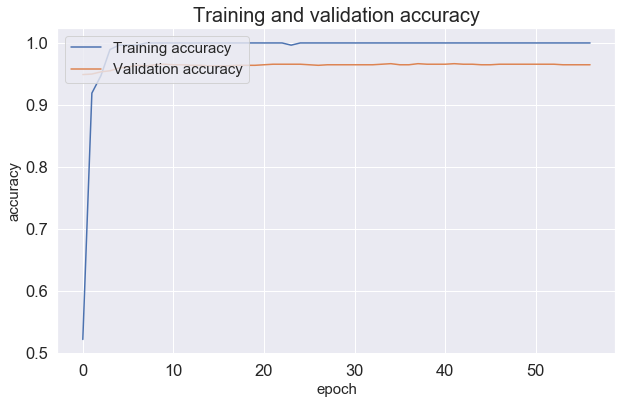

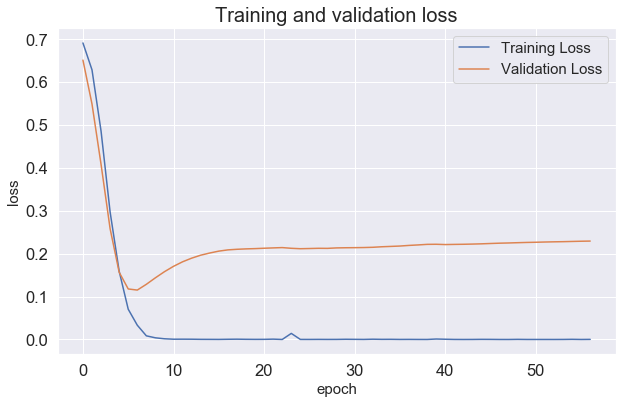

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1075
           1       0.69      0.67      0.68        61

    accuracy                           0.97      1136
   macro avg       0.84      0.83      0.83      1136
weighted avg       0.97      0.97      0.97      1136



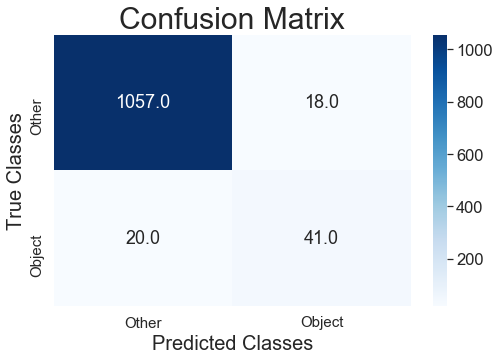

**Processing Label 6 ...**
(282, 20000) (282,)
141 61
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_97 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_97 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_98 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_99 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.95158
 - 0s - loss: 0.0487 - acc: 0.9929 - val_loss: 0.3377 - val_acc: 0.9384
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.95158
 - 1s - loss: 0.0636 - acc: 0.9858 - val_loss: 0.3133 - val_acc: 0.9481
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.95158
 - 1s - loss: 0.0404 - acc: 0.9894 - val_loss: 0.3079 - val_acc: 0.9507
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.95158
 - 0s - loss: 0.0338 - acc: 0.9929 - val_loss: 0.3095 - val_acc: 0.9507
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.95158
 - 1s - loss: 0.0561 - acc: 0.9858 - val_loss: 0.3187 - val_acc: 0.9463
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.95158
 - 0s - loss: 0.0587 - acc: 0.9858 - val_loss: 0.3353 - val_acc: 0.9410
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.95158
 - 0s - loss: 0.0474 - acc: 0.9894 - val_loss: 0.3337 - val_acc: 0.9410
Epoch 55/1000

Epoch 00055: val_acc did n

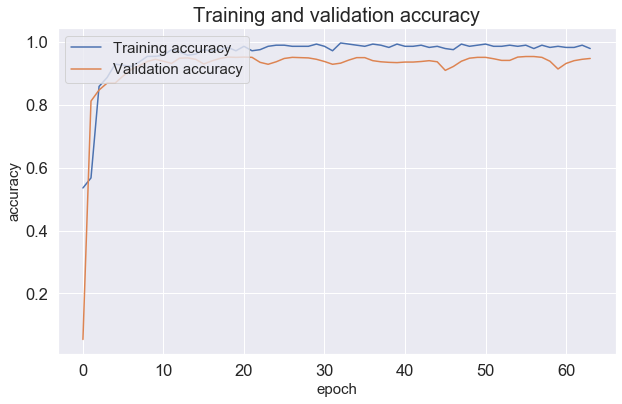

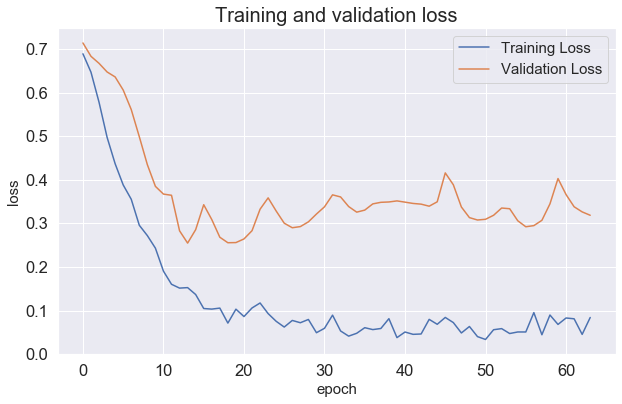

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1075
           1       0.58      0.48      0.52        61

    accuracy                           0.95      1136
   macro avg       0.78      0.73      0.75      1136
weighted avg       0.95      0.95      0.95      1136



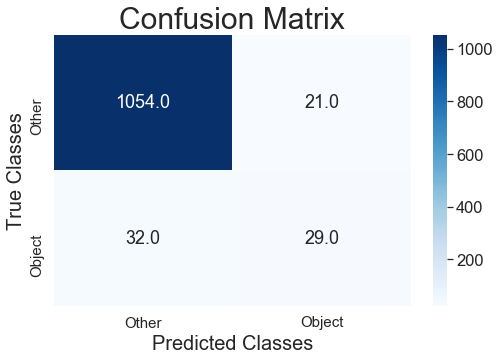

**Processing Label 7 ...**
(240, 20000) (240,)
120 51
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_100 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_100 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_101 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_102 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 47/1000

Epoch 00047: val_acc did not improve from 0.96567
 - 1s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3421 - val_acc: 0.9648
Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.96567
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3445 - val_acc: 0.9639
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.96567
 - 1s - loss: 6.0365e-05 - acc: 1.0000 - val_loss: 0.3472 - val_acc: 0.9639
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.96567
 - 1s - loss: 1.1033e-04 - acc: 1.0000 - val_loss: 0.3499 - val_acc: 0.9648
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.96567
 - 1s - loss: 0.0047 - acc: 0.9958 - val_loss: 0.3551 - val_acc: 0.9621
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.96567
 - 1s - loss: 4.5654e-05 - acc: 1.0000 - val_loss: 0.3605 - val_acc: 0.9604
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.96567
 - 1s - loss: 1.4136e-04 - acc: 1.0000 - val_loss: 0.3662 - val_acc: 0.9569
Epoch 54/1000

Epoch 0005

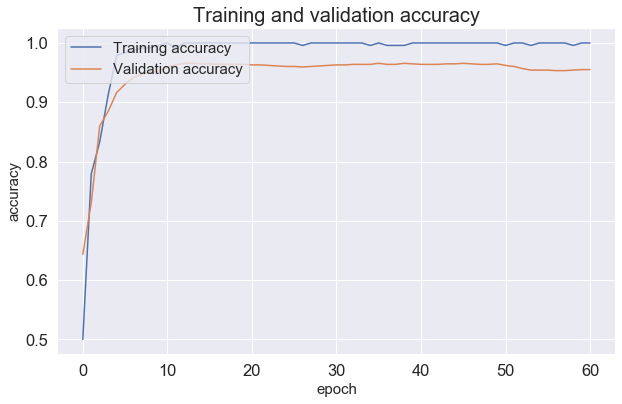

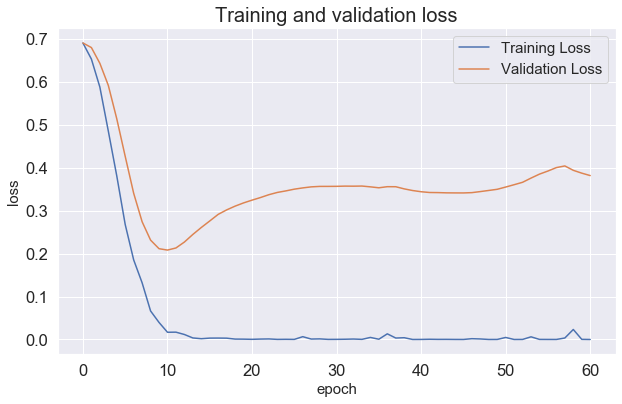

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1085
           1       0.60      0.69      0.64        51

    accuracy                           0.97      1136
   macro avg       0.79      0.83      0.81      1136
weighted avg       0.97      0.97      0.97      1136



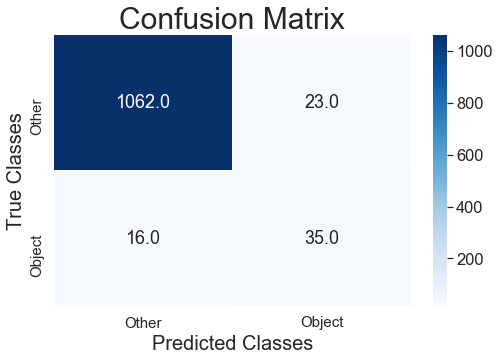

**Processing Label 8 ...**
(208, 20000) (208,)
104 45
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_103 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_103 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_104 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_105 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________


Epoch 00047: val_acc did not improve from 0.98768
 - 0s - loss: 1.5459e-04 - acc: 1.0000 - val_loss: 0.1063 - val_acc: 0.9859
Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.98768
 - 0s - loss: 1.2343e-04 - acc: 1.0000 - val_loss: 0.1070 - val_acc: 0.9868
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.98768
 - 0s - loss: 6.0874e-05 - acc: 1.0000 - val_loss: 0.1077 - val_acc: 0.9868
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.98768
 - 0s - loss: 2.4857e-05 - acc: 1.0000 - val_loss: 0.1083 - val_acc: 0.9868
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.98768
 - 0s - loss: 6.4684e-05 - acc: 1.0000 - val_loss: 0.1088 - val_acc: 0.9868
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.98768
 - 0s - loss: 1.3215e-04 - acc: 1.0000 - val_loss: 0.1092 - val_acc: 0.9868
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.98768
 - 0s - loss: 1.6279e-04 - acc: 1.0000 - val_loss: 0.1094 - val_acc: 0.9868
Epoch 54/1000

Epoch 00054:

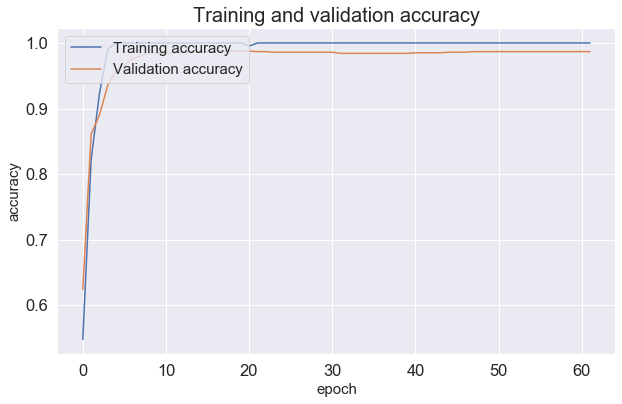

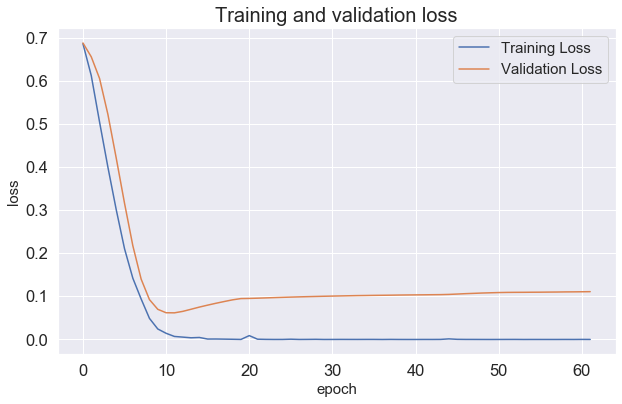

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1091
           1       0.92      0.76      0.83        45

    accuracy                           0.99      1136
   macro avg       0.95      0.88      0.91      1136
weighted avg       0.99      0.99      0.99      1136



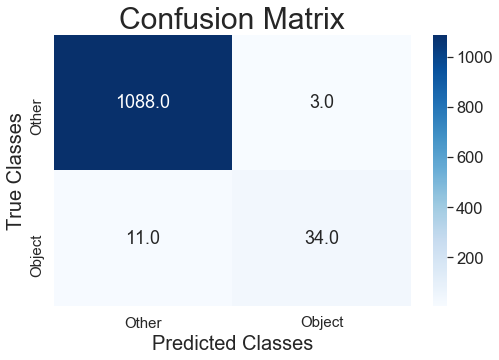

**Processing Label 9 ...**
(144, 20000) (144,)
72 31
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_106 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_106 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_107 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_108 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
_________________

Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.98592
 - 0s - loss: 2.0041e-05 - acc: 1.0000 - val_loss: 0.0943 - val_acc: 0.9850
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.98592
 - 0s - loss: 8.3599e-05 - acc: 1.0000 - val_loss: 0.0944 - val_acc: 0.9850
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.98592
 - 0s - loss: 3.7239e-04 - acc: 1.0000 - val_loss: 0.0948 - val_acc: 0.9850
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.98592
 - 0s - loss: 2.6669e-05 - acc: 1.0000 - val_loss: 0.0951 - val_acc: 0.9850
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.98592
 - 0s - loss: 2.8276e-05 - acc: 1.0000 - val_loss: 0.0954 - val_acc: 0.9850
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.98592
 - 0s - loss: 5.6848e-04 - acc: 1.0000 - val_loss: 0.0979 - val_acc: 0.9842
Epoch 56/1000

Epoch 00056: val_acc did not improve from 0.98592
 - 0s - loss: 4.4212e-05 - acc: 1.0000 - val_loss: 0.1026 - val_acc: 0.9815
Epoch 57/1000

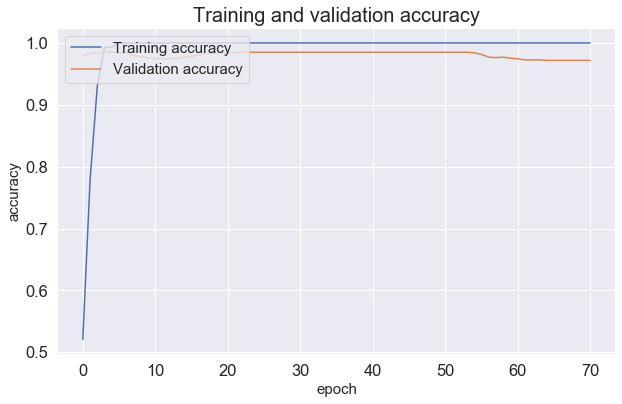

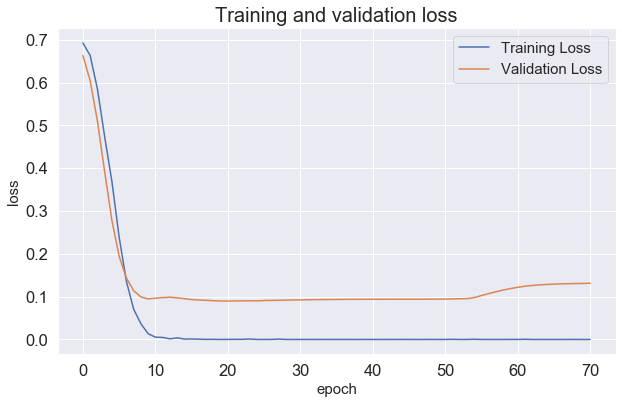

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1105
           1       0.71      0.81      0.76        31

    accuracy                           0.99      1136
   macro avg       0.85      0.90      0.88      1136
weighted avg       0.99      0.99      0.99      1136



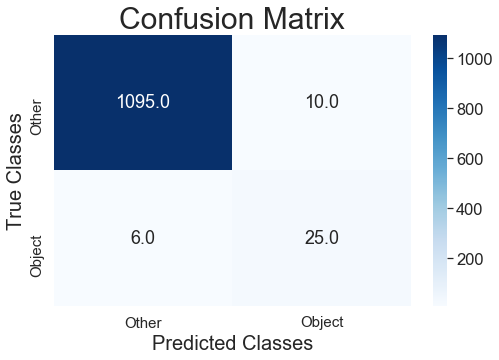

**Processing Label 10 ...**
(134, 20000) (134,)
67 29
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_109 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_109 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_110 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_111 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 47/1000

Epoch 00047: val_acc did not improve from 0.98768
 - 0s - loss: 7.5963e-04 - acc: 1.0000 - val_loss: 0.0871 - val_acc: 0.9850
Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.98768
 - 0s - loss: 2.7388e-04 - acc: 1.0000 - val_loss: 0.0878 - val_acc: 0.9842
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.98768
 - 0s - loss: 2.5061e-04 - acc: 1.0000 - val_loss: 0.0891 - val_acc: 0.9842
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.98768
 - 0s - loss: 1.3412e-04 - acc: 1.0000 - val_loss: 0.0898 - val_acc: 0.9842
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.98768
 - 0s - loss: 7.6436e-04 - acc: 1.0000 - val_loss: 0.0911 - val_acc: 0.9842
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.98768
 - 0s - loss: 1.9416e-04 - acc: 1.0000 - val_loss: 0.0921 - val_acc: 0.9833
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.98768
 - 0s - loss: 6.5294e-04 - acc: 1.0000 - val_loss: 0.0924 - val_acc: 0.9833
Epoch 54/1000

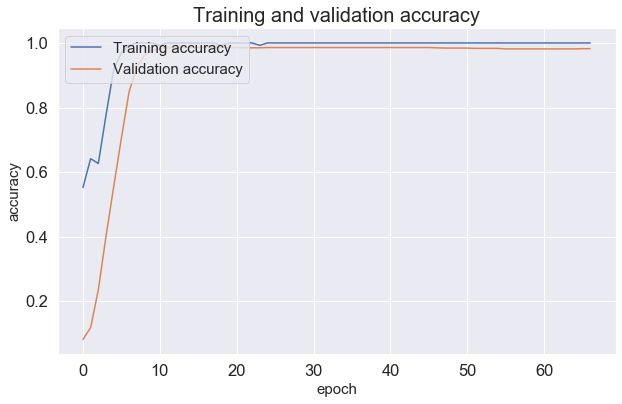

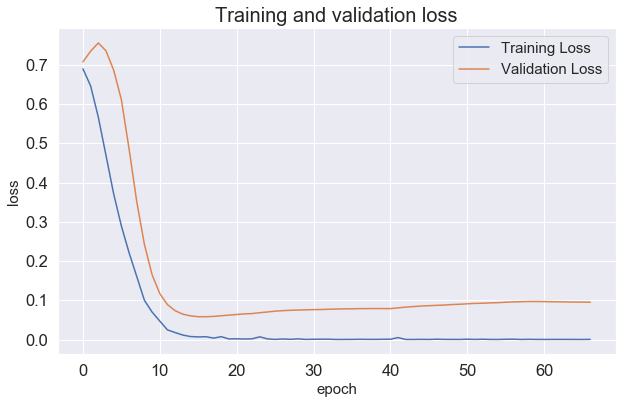

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1107
           1       0.71      0.86      0.78        29

    accuracy                           0.99      1136
   macro avg       0.86      0.93      0.89      1136
weighted avg       0.99      0.99      0.99      1136



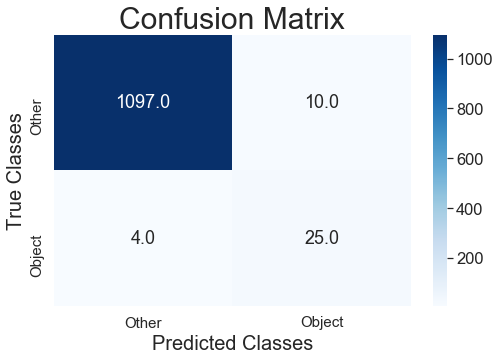

**Processing Label 11 ...**
(128, 20000) (128,)
64 27
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_112 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_112 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_113 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_114 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 46/1000

Epoch 00046: val_acc did not improve from 0.98415
 - 0s - loss: 1.9306e-04 - acc: 1.0000 - val_loss: 0.1500 - val_acc: 0.9824
Epoch 47/1000

Epoch 00047: val_acc did not improve from 0.98415
 - 0s - loss: 4.3275e-04 - acc: 1.0000 - val_loss: 0.1508 - val_acc: 0.9824
Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.98415
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.1517 - val_acc: 0.9824
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.98415
 - 0s - loss: 2.9414e-04 - acc: 1.0000 - val_loss: 0.1525 - val_acc: 0.9824
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.98415
 - 0s - loss: 2.0163e-04 - acc: 1.0000 - val_loss: 0.1532 - val_acc: 0.9824
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.98415
 - 0s - loss: 2.8135e-04 - acc: 1.0000 - val_loss: 0.1539 - val_acc: 0.9824
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.98415
 - 0s - loss: 6.8925e-04 - acc: 1.0000 - val_loss: 0.1545 - val_acc: 0.9824
Epoch 53/1000

Ep

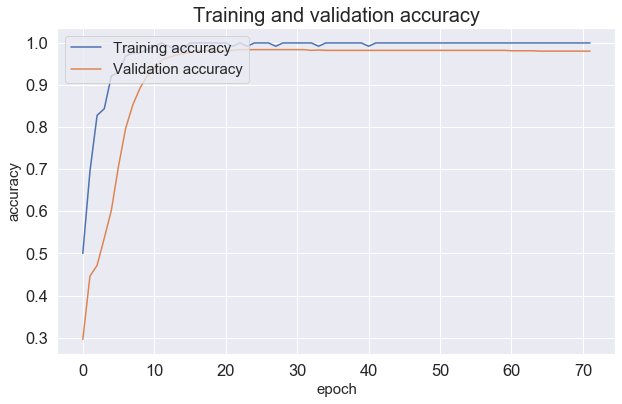

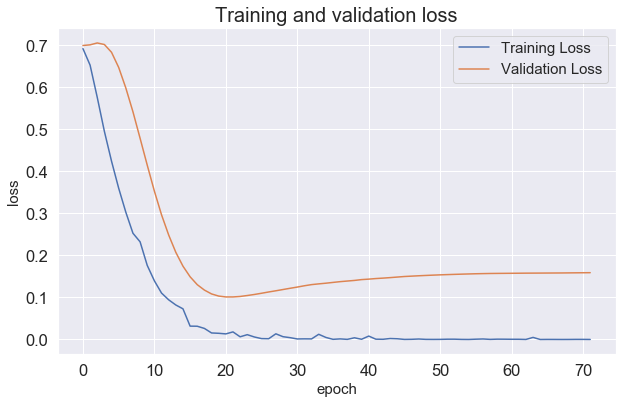

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1109
           1       0.70      0.59      0.64        27

    accuracy                           0.98      1136
   macro avg       0.84      0.79      0.82      1136
weighted avg       0.98      0.98      0.98      1136



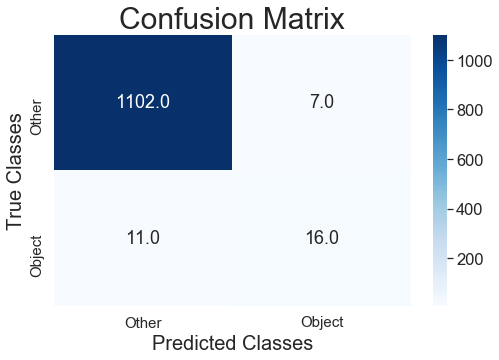

**Processing Label 12 ...**
(122, 20000) (122,)
61 26
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_115 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_115 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_116 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_117 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.98592
 - 0s - loss: 4.0655e-04 - acc: 1.0000 - val_loss: 0.1027 - val_acc: 0.9842
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.98592
 - 0s - loss: 6.0076e-05 - acc: 1.0000 - val_loss: 0.1033 - val_acc: 0.9842
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.98592
 - 0s - loss: 4.8059e-04 - acc: 1.0000 - val_loss: 0.1031 - val_acc: 0.9842
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.98592
 - 0s - loss: 7.2876e-05 - acc: 1.0000 - val_loss: 0.1034 - val_acc: 0.9859
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.98592
 - 0s - loss: 4.9728e-05 - acc: 1.0000 - val_loss: 0.1034 - val_acc: 0.9859
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.98592
 - 0s - loss: 8.6615e-05 - acc: 1.0000 - val_loss: 0.1037 - val_acc: 0.9859
Epoch 56/1000

Epoch 00056: val_acc did not improve from 0.98592
 - 0s - loss: 2.0545e-05 - acc: 1.0000 - val_loss: 0.1035 - val_acc: 0.9859
Epoch 57/1000

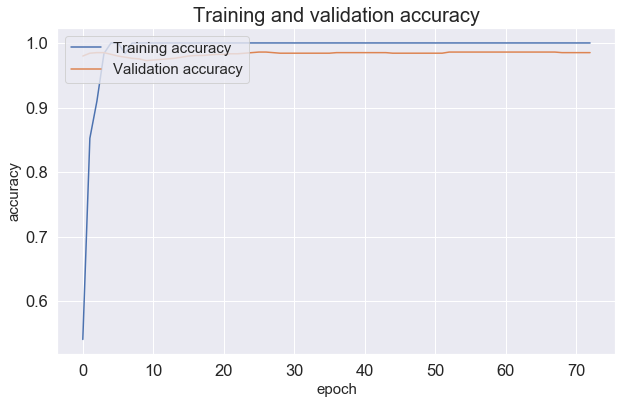

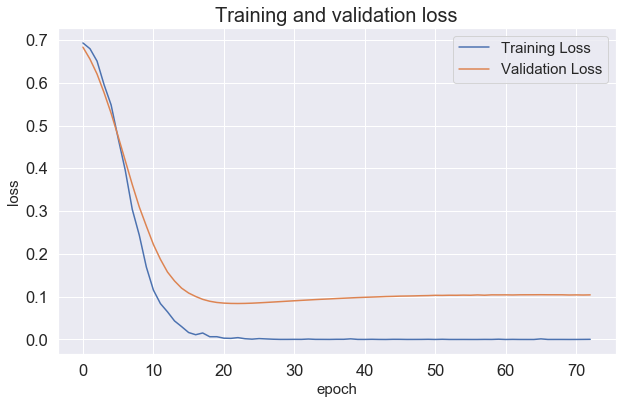

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1110
           1       0.65      0.85      0.73        26

    accuracy                           0.99      1136
   macro avg       0.82      0.92      0.86      1136
weighted avg       0.99      0.99      0.99      1136



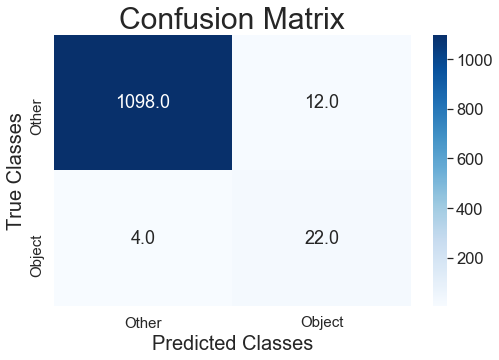

**Processing Label 13 ...**
(118, 20000) (118,)
59 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_118 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_118 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_119 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_120 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 43/1000

Epoch 00043: val_acc did not improve from 0.99648
 - 0s - loss: 0.0470 - acc: 0.9915 - val_loss: 0.0331 - val_acc: 0.9938
Epoch 44/1000

Epoch 00044: val_acc did not improve from 0.99648
 - 0s - loss: 0.0451 - acc: 0.9915 - val_loss: 0.0361 - val_acc: 0.9938
Epoch 45/1000

Epoch 00045: val_acc did not improve from 0.99648
 - 0s - loss: 0.0317 - acc: 0.9915 - val_loss: 0.0389 - val_acc: 0.9930
Epoch 46/1000

Epoch 00046: val_acc did not improve from 0.99648
 - 0s - loss: 0.0264 - acc: 0.9915 - val_loss: 0.0417 - val_acc: 0.9921
Epoch 47/1000

Epoch 00047: val_acc did not improve from 0.99648
 - 0s - loss: 0.0317 - acc: 0.9915 - val_loss: 0.0442 - val_acc: 0.9921
Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.99648
 - 0s - loss: 0.0286 - acc: 0.9915 - val_loss: 0.0468 - val_acc: 0.9912
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.99648
 - 0s - loss: 0.0665 - acc: 0.9915 - val_loss: 0.0496 - val_acc: 0.9912
Epoch 50/1000

Epoch 00050: val_acc did n

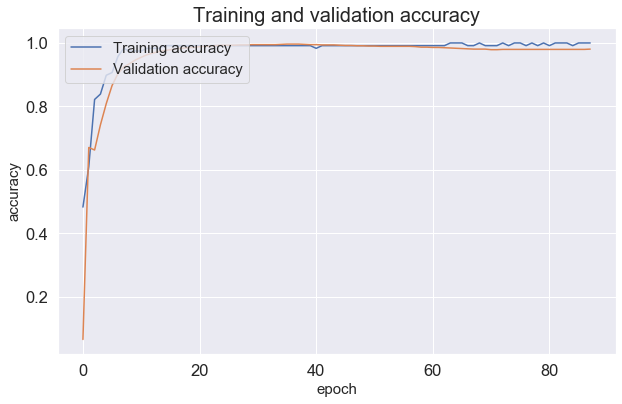

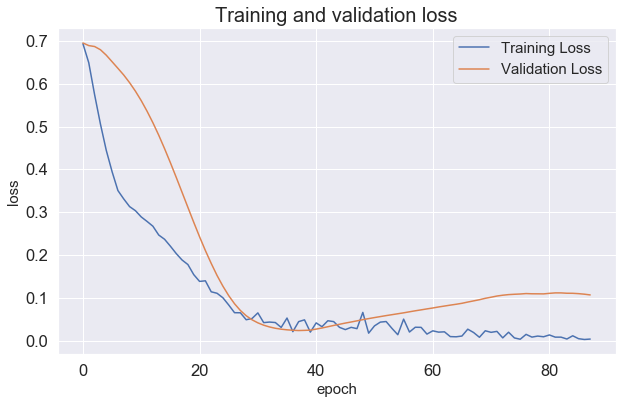

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1111
           1       0.92      0.92      0.92        25

    accuracy                           1.00      1136
   macro avg       0.96      0.96      0.96      1136
weighted avg       1.00      1.00      1.00      1136



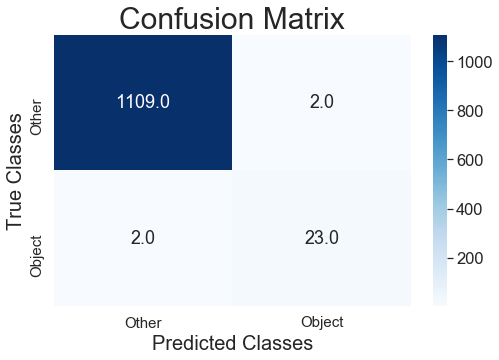

**Processing Label 14 ...**
(116, 20000) (116,)
58 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_121 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_121 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_122 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_123 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 44/1000

Epoch 00044: val_acc did not improve from 0.99032
 - 0s - loss: 1.8766e-04 - acc: 1.0000 - val_loss: 0.0869 - val_acc: 0.9886
Epoch 45/1000

Epoch 00045: val_acc did not improve from 0.99032
 - 0s - loss: 1.6119e-04 - acc: 1.0000 - val_loss: 0.0865 - val_acc: 0.9886
Epoch 46/1000

Epoch 00046: val_acc did not improve from 0.99032
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9894
Epoch 47/1000

Epoch 00047: val_acc did not improve from 0.99032
 - 0s - loss: 7.5145e-04 - acc: 1.0000 - val_loss: 0.0860 - val_acc: 0.9903
Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.99032
 - 0s - loss: 1.6016e-04 - acc: 1.0000 - val_loss: 0.0859 - val_acc: 0.9903
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.99032
 - 0s - loss: 1.2510e-04 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9903
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.99032
 - 0s - loss: 9.3811e-05 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9903
Epoch 51/1000

Ep

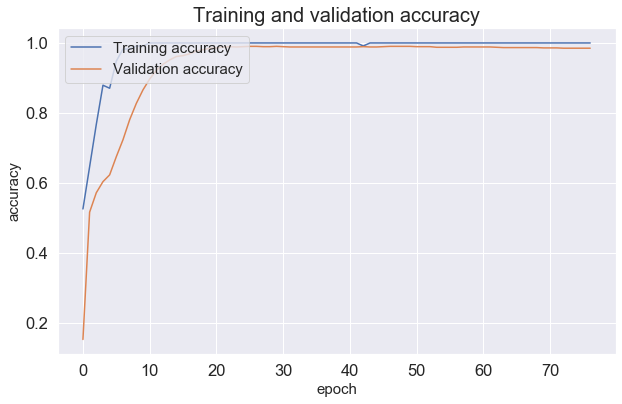

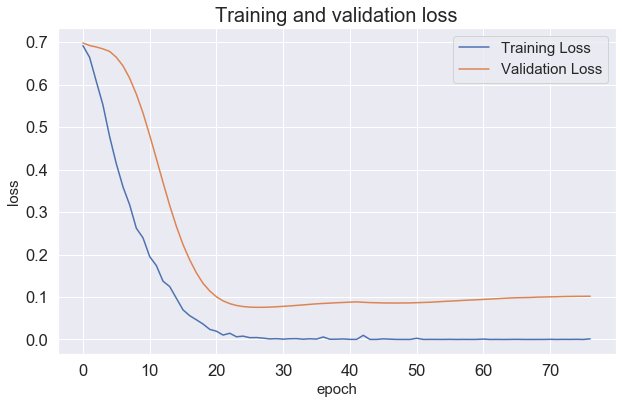

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1111
           1       0.77      0.80      0.78        25

    accuracy                           0.99      1136
   macro avg       0.88      0.90      0.89      1136
weighted avg       0.99      0.99      0.99      1136



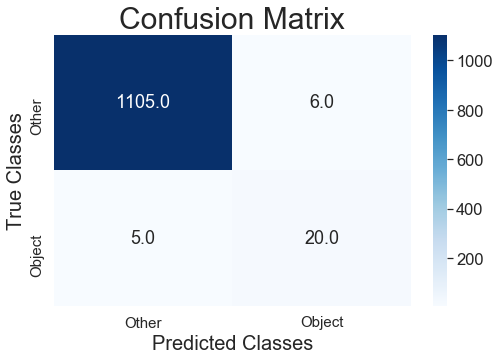

**Processing Label 15 ...**
(114, 20000) (114,)
57 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_124 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_124 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_125 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_125 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_126 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 45/1000

Epoch 00045: val_acc did not improve from 0.99472
 - 0s - loss: 7.5072e-05 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9947
Epoch 46/1000

Epoch 00046: val_acc did not improve from 0.99472
 - 0s - loss: 5.7323e-05 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9947
Epoch 47/1000

Epoch 00047: val_acc did not improve from 0.99472
 - 0s - loss: 1.9033e-05 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9947
Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.99472
 - 0s - loss: 6.9418e-05 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9947
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.99472
 - 0s - loss: 4.4182e-05 - acc: 1.0000 - val_loss: 0.0410 - val_acc: 0.9947
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.99472
 - 0s - loss: 3.1259e-05 - acc: 1.0000 - val_loss: 0.0410 - val_acc: 0.9947
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.99472
 - 0s - loss: 1.0005e-04 - acc: 1.0000 - val_loss: 0.0411 - val_acc: 0.9947
Epoch 52/1000

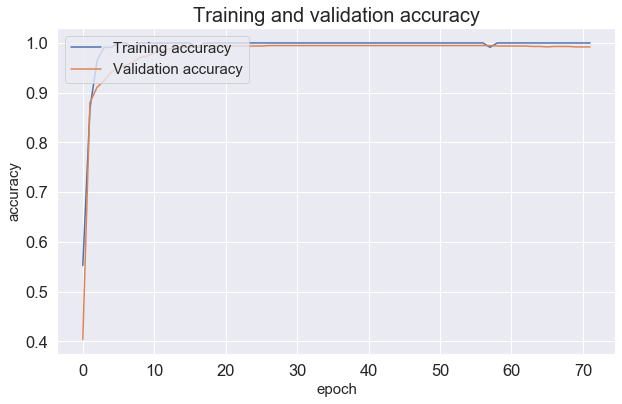

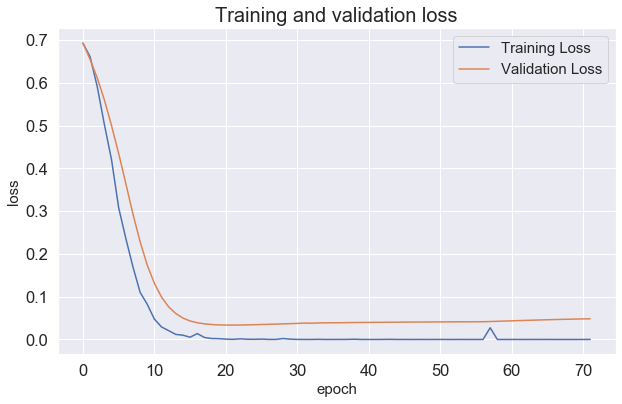

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1111
           1       0.88      0.88      0.88        25

    accuracy                           0.99      1136
   macro avg       0.94      0.94      0.94      1136
weighted avg       0.99      0.99      0.99      1136



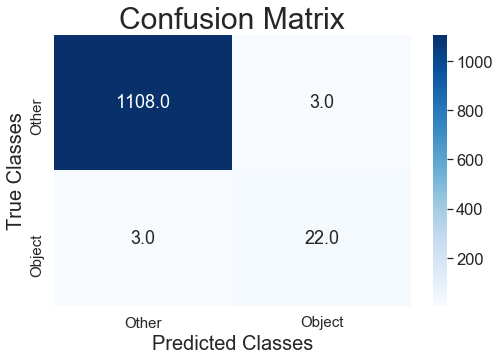

**Processing Label 16 ...**
(114, 20000) (114,)
57 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_127 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_127 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_128 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_129 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________

Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.96039
 - 0s - loss: 2.3132e-05 - acc: 1.0000 - val_loss: 0.2762 - val_acc: 0.9595
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.96039
 - 0s - loss: 1.2126e-05 - acc: 1.0000 - val_loss: 0.2768 - val_acc: 0.9595
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.96039
 - 0s - loss: 0.0087 - acc: 0.9912 - val_loss: 0.2852 - val_acc: 0.9595
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.96039
 - 0s - loss: 6.1693e-06 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.9577
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.96039
 - 0s - loss: 1.2157e-04 - acc: 1.0000 - val_loss: 0.3003 - val_acc: 0.9569
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.96039
 - 0s - loss: 1.7669e-04 - acc: 1.0000 - val_loss: 0.3067 - val_acc: 0.9569
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.96039
 - 0s - loss: 2.6044e-05 - acc: 1.0000 - val_loss: 0.3128 - val_acc: 0.9569
Epoch 55/1000

Ep

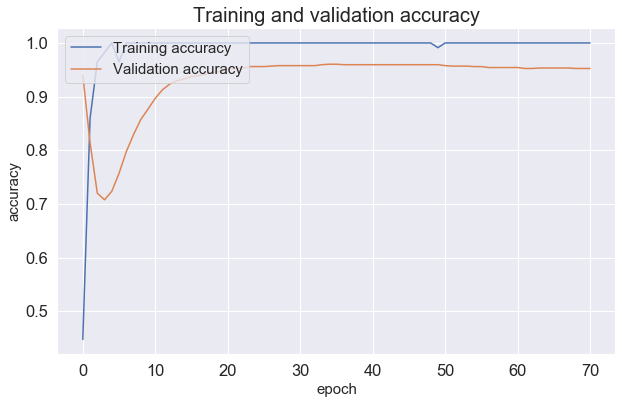

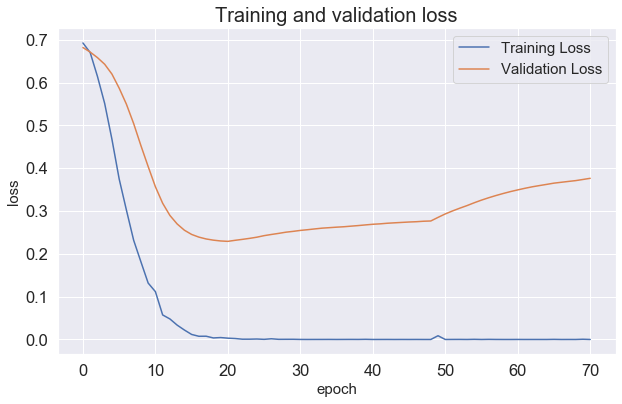

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1111
           1       0.35      0.92      0.51        25

    accuracy                           0.96      1136
   macro avg       0.67      0.94      0.74      1136
weighted avg       0.98      0.96      0.97      1136



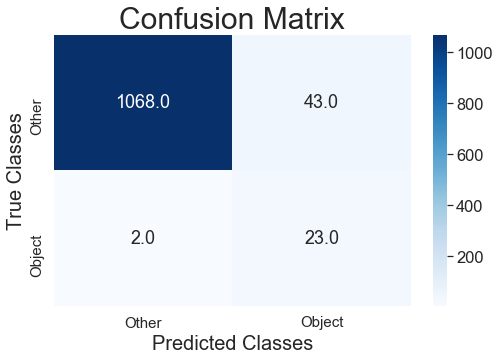

**Processing Label 17 ...**
(96, 20000) (96,)
48 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_130 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_130 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_131 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_132 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
__________________

Epoch 45/1000

Epoch 00045: val_acc did not improve from 0.98504
 - 0s - loss: 1.3939e-04 - acc: 1.0000 - val_loss: 0.0798 - val_acc: 0.9842
Epoch 46/1000

Epoch 00046: val_acc did not improve from 0.98504
 - 0s - loss: 1.0876e-05 - acc: 1.0000 - val_loss: 0.0806 - val_acc: 0.9833
Epoch 47/1000

Epoch 00047: val_acc did not improve from 0.98504
 - 0s - loss: 4.6063e-05 - acc: 1.0000 - val_loss: 0.0814 - val_acc: 0.9842
Epoch 48/1000

Epoch 00048: val_acc did not improve from 0.98504
 - 0s - loss: 2.6610e-05 - acc: 1.0000 - val_loss: 0.0820 - val_acc: 0.9833
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.98504
 - 0s - loss: 1.9576e-04 - acc: 1.0000 - val_loss: 0.0827 - val_acc: 0.9824
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.98504
 - 0s - loss: 1.7589e-04 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9815
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.98504
 - 0s - loss: 1.8210e-04 - acc: 1.0000 - val_loss: 0.0840 - val_acc: 0.9815
Epoch 52/1000

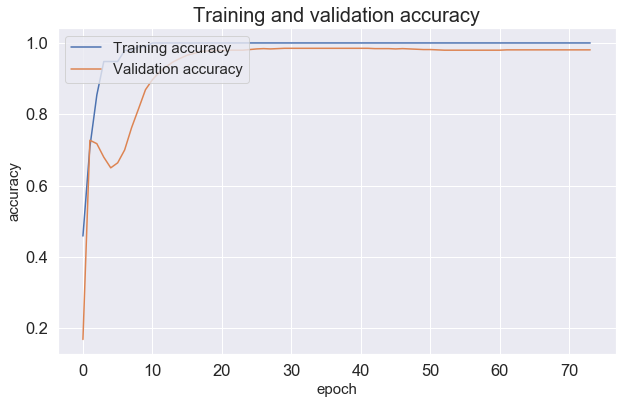

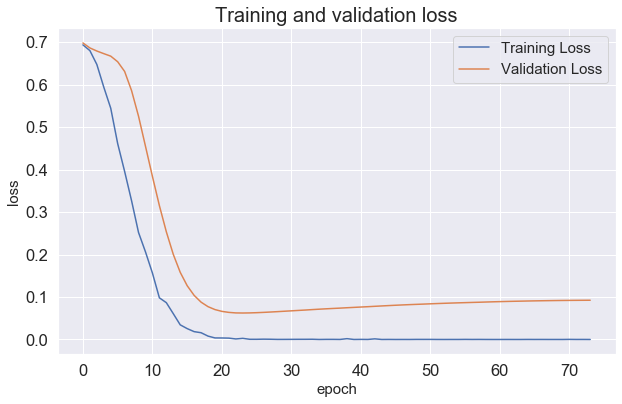

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1116
           1       0.57      0.60      0.59        20

    accuracy                           0.99      1136
   macro avg       0.78      0.80      0.79      1136
weighted avg       0.99      0.99      0.99      1136



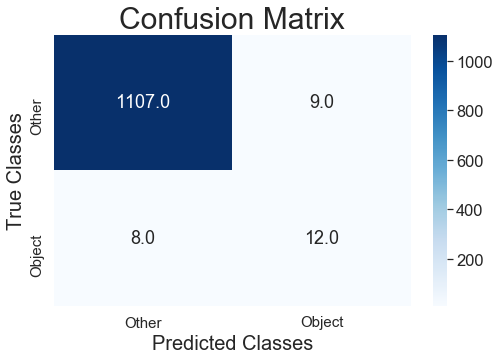

**Processing Label 18 ...**
(86, 20000) (86,)
43 18
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_133 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_133 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_134 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_135 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
__________________

Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.98768
 - 0s - loss: 8.8153e-04 - acc: 1.0000 - val_loss: 0.1783 - val_acc: 0.9701
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.98768
 - 0s - loss: 3.7156e-04 - acc: 1.0000 - val_loss: 0.1790 - val_acc: 0.9701
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.98768
 - 0s - loss: 8.1919e-04 - acc: 1.0000 - val_loss: 0.1797 - val_acc: 0.9692
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.98768
 - 0s - loss: 5.0753e-04 - acc: 1.0000 - val_loss: 0.1805 - val_acc: 0.9683
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.98768
 - 0s - loss: 4.6956e-06 - acc: 1.0000 - val_loss: 0.1811 - val_acc: 0.9683
Epoch 56/1000

Epoch 00056: val_acc did not improve from 0.98768
 - 0s - loss: 2.7796e-05 - acc: 1.0000 - val_loss: 0.1817 - val_acc: 0.9683
Epoch 57/1000

Epoch 00057: val_acc did not improve from 0.98768
 - 0s - loss: 5.6021e-05 - acc: 1.0000 - val_loss: 0.1822 - val_acc: 0.9683
Epoch 58/1000

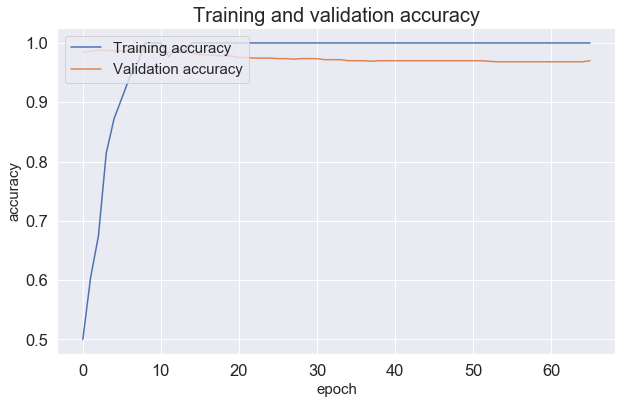

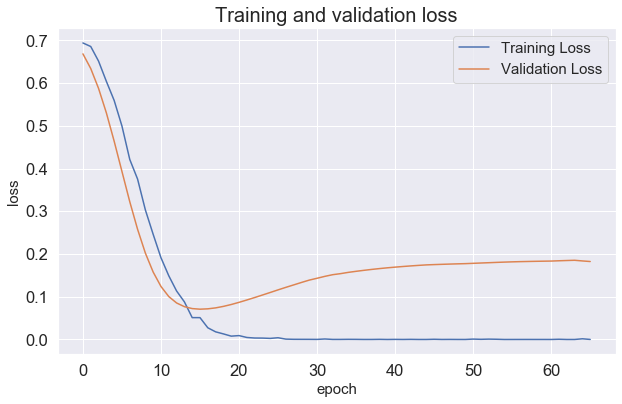

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1118
           1       0.62      0.56      0.59        18

    accuracy                           0.99      1136
   macro avg       0.81      0.78      0.79      1136
weighted avg       0.99      0.99      0.99      1136



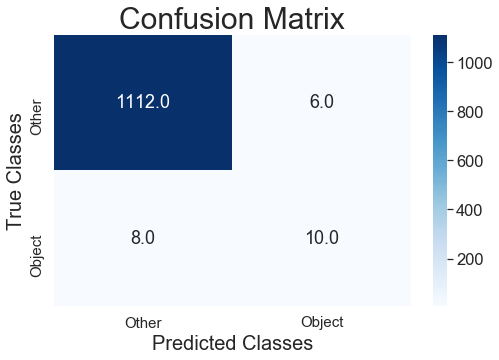

**Processing Label 19 ...**
(86, 20000) (86,)
43 18
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_136 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_136 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_137 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_138 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
__________________

Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.98504
 - 0s - loss: 2.1072e-04 - acc: 1.0000 - val_loss: 0.2283 - val_acc: 0.9683
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.98504
 - 0s - loss: 2.4142e-06 - acc: 1.0000 - val_loss: 0.2279 - val_acc: 0.9683
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.98504
 - 0s - loss: 4.6281e-04 - acc: 1.0000 - val_loss: 0.2276 - val_acc: 0.9701
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.98504
 - 0s - loss: 3.8141e-05 - acc: 1.0000 - val_loss: 0.2274 - val_acc: 0.9701
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.98504
 - 0s - loss: 2.9142e-04 - acc: 1.0000 - val_loss: 0.2273 - val_acc: 0.9701
Epoch 56/1000

Epoch 00056: val_acc did not improve from 0.98504
 - 0s - loss: 4.4876e-04 - acc: 1.0000 - val_loss: 0.2273 - val_acc: 0.9701
Epoch 57/1000

Epoch 00057: val_acc did not improve from 0.98504
 - 0s - loss: 9.4925e-06 - acc: 1.0000 - val_loss: 0.2272 - val_acc: 0.9701
Epoch 58/1000

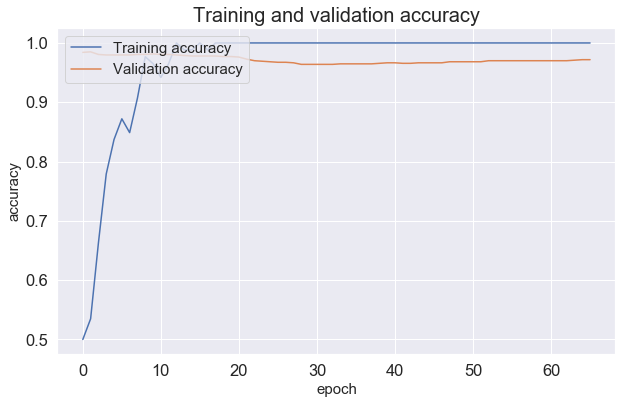

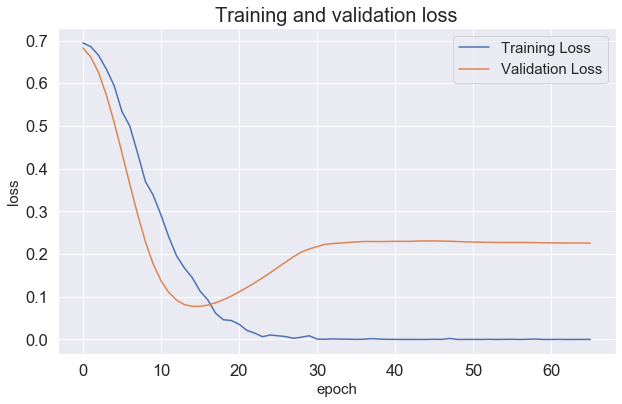

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1118
           1       0.54      0.39      0.45        18

    accuracy                           0.99      1136
   macro avg       0.76      0.69      0.72      1136
weighted avg       0.98      0.99      0.98      1136



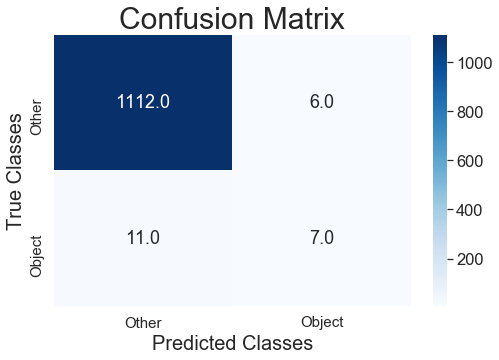

**Processing Label other ...**
(796, 20000) (796,)
398 171
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_139 (Dropout)        (None, 20000)             0         
_________________________________________________________________
dense_139 (Dense)            (None, 32)                640032    
_________________________________________________________________
dropout_140 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_141 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
___________

Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.90053
 - 1s - loss: 0.0161 - acc: 0.9962 - val_loss: 0.8675 - val_acc: 0.8512
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.90053
 - 1s - loss: 0.0280 - acc: 0.9925 - val_loss: 0.7992 - val_acc: 0.8794
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.90053
 - 1s - loss: 0.0416 - acc: 0.9862 - val_loss: 0.8130 - val_acc: 0.8653
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.90053
 - 1s - loss: 0.0158 - acc: 0.9962 - val_loss: 0.8576 - val_acc: 0.8495
Epoch 00053: early stopping
Validation accuracy: 0.8494718074798584, loss: 0.8575526408746209


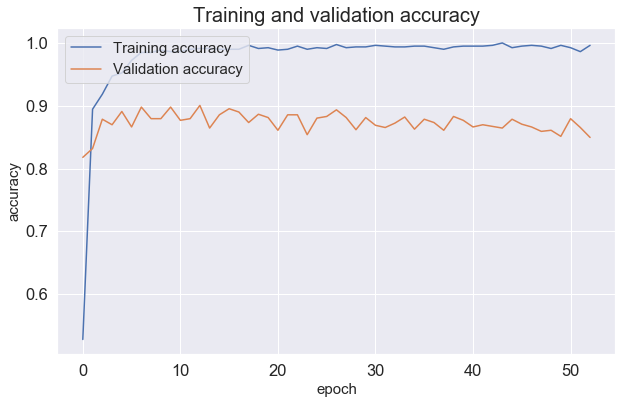

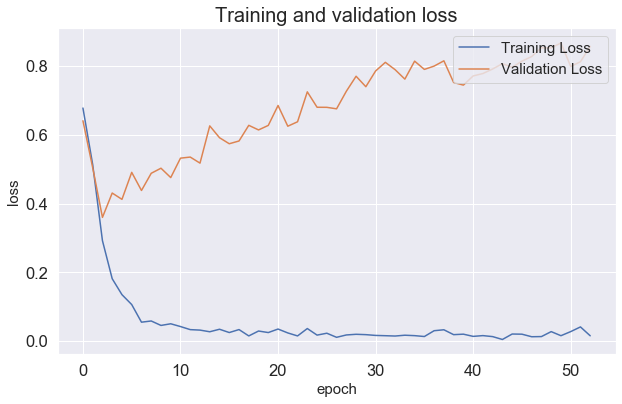

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       965
           1       0.69      0.62      0.65       171

    accuracy                           0.90      1136
   macro avg       0.81      0.79      0.80      1136
weighted avg       0.90      0.90      0.90      1136



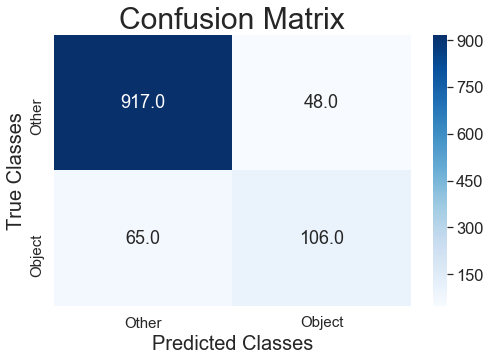

In [1439]:
X = kl_email['Multi-Fields Processed'] 
ylabels = kl_email[count_df['combined_labels'].unique()] 
confusion, class_report, best_model, predicted, y_test_a = [], [], [], []

labels = count_df['combined_labels'].unique()
for label in labels:
    print('**Processing Label {} ...**'.format(label))
    X_train, X_test, y_train, y_test = train_test_split(X, ylabels[label], test_size=0.3, random_state=0, stratify=ylabels[label])#, shuffle=False)      
    X_train_vec, X_test_vec = ngram_vectorize((X_train), (y_train), (X_test))
    rus = RandomUnderSampler(random_state=0)
    X_rus, y_rus = rus.fit_sample(X_train_vec, y_train)
    print(X_rus.shape, y_rus.shape)
    print(y_rus.sum(),y_test.sum())
    data = (X_rus,y_rus),(X_test_vec,y_test)  
    num_classes = 2
    c_m, c_r, b_m, p=train_ngram_model(data,num_classes,batch_size=128,layers=3,units=32,dropout_rate=0.3)
    confusion.append(c_m)
    class_report.append(c_r)
    best_model.append(b_m)
    predicted.append(p)
    y_test_a.append(y_test)


In [1414]:
# Best Model
X = kl_email['Multi-Fields Processed'] 
ylabels = kl_email[count_df['combined_labels'].unique()] 
label = 0
X_train, X_test, y_train, y_test = train_test_split(X, ylabels[label], test_size=0.3, random_state=0)#, stratify=ylabels[label])#, shuffle=False)      
X_train_vec, X_test_vec = ngram_vectorize((X_train), (y_train), (X_test))
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_sample(X_train_vec, y_train)
print(X_rus.shape, y_rus.shape)
print(y_rus.sum(),y_test.sum())
data = (X_rus,y_rus),(X_test_vec,y_test)  
num_classes = 2
train_ngram_model(data,num_classes,batch_size=128,layers=3,units=32,dropout_rate=0.3)

(1018, 20000) (1018,)
509 206
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_53 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_54 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_55 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
________________________________________

Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.89085
 - 2s - loss: 0.0242 - acc: 0.9902 - val_loss: 0.6163 - val_acc: 0.8803
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.89085
 - 2s - loss: 0.0259 - acc: 0.9872 - val_loss: 0.6261 - val_acc: 0.8856
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.89085
 - 2s - loss: 0.0170 - acc: 0.9941 - val_loss: 0.6535 - val_acc: 0.8732
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.89085
 - 2s - loss: 0.0183 - acc: 0.9912 - val_loss: 0.6670 - val_acc: 0.8785
Epoch 00053: early stopping
Validation accuracy: 0.8785211443901062, loss: 0.6669617899706666


(0.87852114, 0.6669617899706666)

Accuracy: 0.8908450704225352
Precision: 0.6990291262135923
Recall: 0.6990291262135923
F1: 0.6990291262135923
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       930
           1       0.70      0.70      0.70       206

    accuracy                           0.89      1136
   macro avg       0.82      0.82      0.82      1136
weighted avg       0.89      0.89      0.89      1136



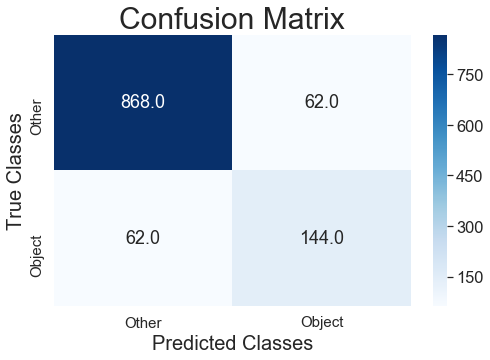

In [1416]:
# Best Model
best_model_path = './SavedModel/Model.epoch_016-val_acc_0.8908.h5'
best_model = tf.keras.models.load_model(best_model_path)
predicted =best_model.predict(X_test_vec)
predicted_c = (predicted>0.5)
plot_evaluation(y_test, predicted_c)

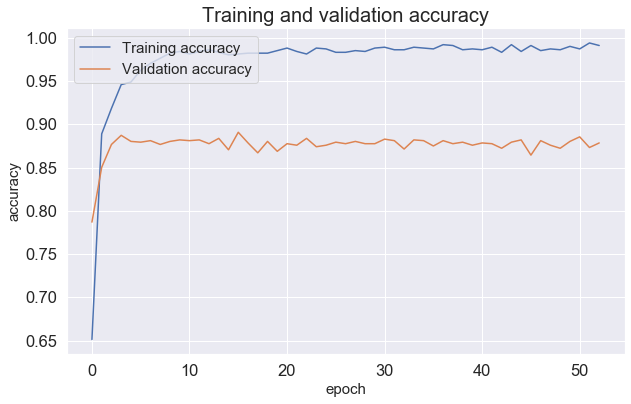

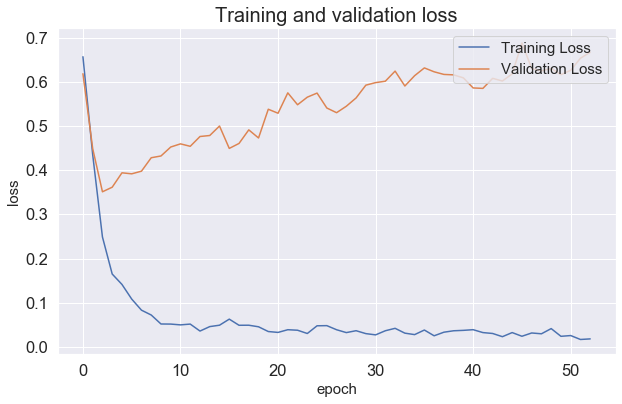

In [1417]:
with open('./SavedModel/trainHistory', 'rb') as pickle_file:
    history_load = pickle.load(pickle_file)

plot_histrory(history_load)

# SMOTE

In [ ]:
# Vectorize texts.
x_train, x_test = ngram_vectorize(
        (X_train), (y_train), (X_test))
data = (x_train,y_train), (x_test, y_test)

In [603]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE
#Over-sampling: SMOTE
#SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
#based on those that already exist. It works randomly picking a point from the minority class and computing 
#the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
#We'll use ratio='minority' to resample the minority class.
smote = SMOTE('minority', random_state=0)
#X_train = pd.DataFrame(X_train, columns =['Message']) # the features we want to analyze
#
#print(x_train.shape)
#print(bow_vector.get_feature_names())
#print(x_train.toarray())

In [629]:
X_train_vec, X_test_vec = ngram_vectorize((X_train), (y_train), (X_test))
print(X_train_vec.shape)

vocabulary length: 358682
(2814, 20000)


In [610]:
print(y_train.sum())

500


In [611]:
X_sm, y_sm = smote.fit_sample(X_train_vec, y_train)
print(X_sm.shape, y_sm.shape)
y_sm.sum()

(4628, 20000) (4628,)


2314

In [616]:
data = (X_sm,y_sm),(X_test_vec,y_test)  
train_ngram_model0(data,2)

Train on 4628 samples, validate on 1207 samples
Epoch 1/1000

Epoch 00001: val_acc improved from -inf to 0.84590, saving model to ./SavedModel/Model.epoch_001-val_acc_0.8459.h5
 - 9s - loss: 0.6295 - acc: 0.8604 - val_loss: 0.6090 - val_acc: 0.8459
Epoch 2/1000

Epoch 00002: val_acc improved from 0.84590 to 0.86993, saving model to ./SavedModel/Model.epoch_002-val_acc_0.8699.h5
 - 6s - loss: 0.5216 - acc: 0.9138 - val_loss: 0.5307 - val_acc: 0.8699
Epoch 3/1000

Epoch 00003: val_acc improved from 0.86993 to 0.87158, saving model to ./SavedModel/Model.epoch_003-val_acc_0.8716.h5
 - 6s - loss: 0.4513 - acc: 0.9207 - val_loss: 0.4806 - val_acc: 0.8716
Epoch 4/1000

Epoch 00004: val_acc improved from 0.87158 to 0.87490, saving model to ./SavedModel/Model.epoch_004-val_acc_0.8749.h5
 - 6s - loss: 0.4009 - acc: 0.9263 - val_loss: 0.4457 - val_acc: 0.8749
Epoch 5/1000

Epoch 00005: val_acc did not improve from 0.87490
 - 6s - loss: 0.3623 - acc: 0.9339 - val_loss: 0.4185 - val_acc: 0.8724
Epo

Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.89395
 - 5s - loss: 0.0917 - acc: 0.9777 - val_loss: 0.2853 - val_acc: 0.8940
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.89395
 - 6s - loss: 0.0889 - acc: 0.9773 - val_loss: 0.2863 - val_acc: 0.8940
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.89395
 - 7s - loss: 0.0870 - acc: 0.9788 - val_loss: 0.2870 - val_acc: 0.8940
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.89395
 - 6s - loss: 0.0861 - acc: 0.9797 - val_loss: 0.2886 - val_acc: 0.8940
Epoch 56/1000

Epoch 00056: val_acc improved from 0.89395 to 0.89561, saving model to ./SavedModel/Model.epoch_056-val_acc_0.8956.h5
 - 7s - loss: 0.0859 - acc: 0.9806 - val_loss: 0.2879 - val_acc: 0.8956
Epoch 57/1000

Epoch 00057: val_acc did not improve from 0.89561
 - 6s - loss: 0.0846 - acc: 0.9808 - val_loss: 0.2887 - val_acc: 0.8948
Epoch 58/1000

Epoch 00058: val_acc did not improve from 0.89561
 - 5s - loss: 0.0856 - acc: 0.9771 - val_loss

Epoch 112/1000

Epoch 00112: val_acc did not improve from 0.89561
 - 7s - loss: 0.0540 - acc: 0.9842 - val_loss: 0.3335 - val_acc: 0.8873
Epoch 113/1000

Epoch 00113: val_acc did not improve from 0.89561
 - 6s - loss: 0.0566 - acc: 0.9836 - val_loss: 0.3327 - val_acc: 0.8865
Epoch 114/1000

Epoch 00114: val_acc did not improve from 0.89561
 - 6s - loss: 0.0548 - acc: 0.9868 - val_loss: 0.3344 - val_acc: 0.8865
Epoch 115/1000

Epoch 00115: val_acc did not improve from 0.89561
 - 6s - loss: 0.0521 - acc: 0.9847 - val_loss: 0.3363 - val_acc: 0.8857
Epoch 116/1000

Epoch 00116: val_acc did not improve from 0.89561
 - 5s - loss: 0.0513 - acc: 0.9866 - val_loss: 0.3389 - val_acc: 0.8857
Epoch 117/1000

Epoch 00117: val_acc did not improve from 0.89561
 - 6s - loss: 0.0543 - acc: 0.9838 - val_loss: 0.3375 - val_acc: 0.8857
Epoch 118/1000

Epoch 00118: val_acc did not improve from 0.89561
 - 6s - loss: 0.0527 - acc: 0.9862 - val_loss: 0.3413 - val_acc: 0.8865
Epoch 119/1000

Epoch 00119: val_a

(0.88483846, 0.3520107012004426)

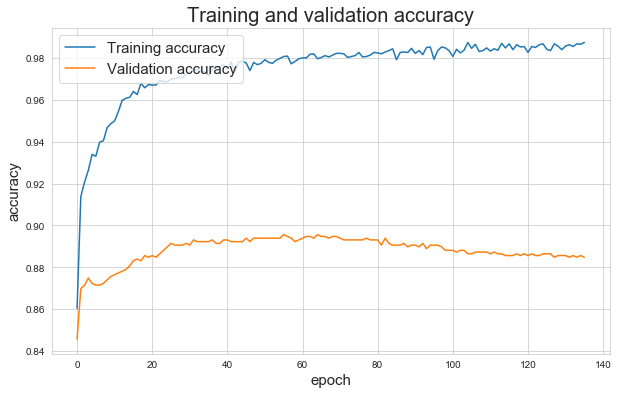

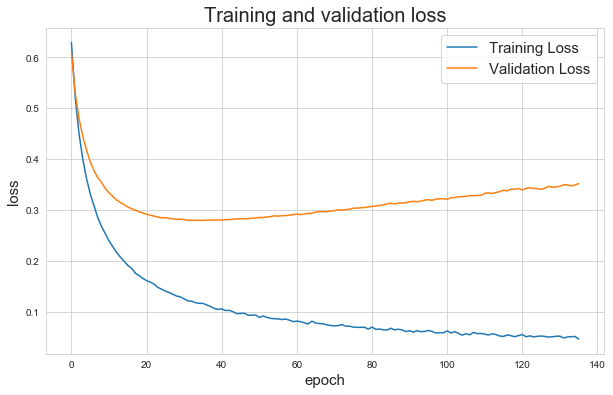

In [620]:
with open('./SavedModel/trainHistory', 'rb') as pickle_file:
    history_load = pickle.load(pickle_file)

plot_histrory(history_load)

In [624]:
best_model_path = './SavedModel/Model.epoch_056-val_acc_0.8956.h5'
best_model = tf.keras.models.load_model(best_model_path)
predicted =best_model.predict(X_test_vec)
predicted_c = (predicted>0.5)
plot_evaluation(y_test, predicted_c)

Logistic Regression Accuracy: 0.8956089478044739
Logistic Regression Precision: 0.8396946564885496
Logistic Regression Recall: 0.5116279069767442
Logistic Regression F1: 0.6358381502890175


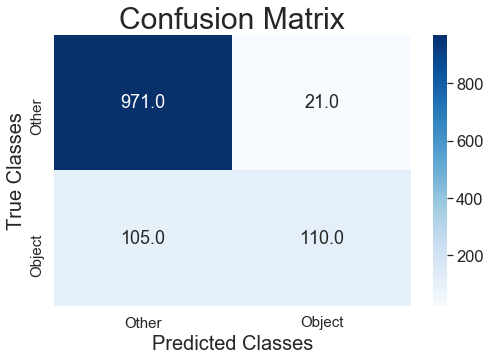

# NonSmote

In [630]:
data = (X_train_vec,y_train),(X_test_vec,y_test)  
train_ngram_model0(data,2)

Train on 2814 samples, validate on 1207 samples
Epoch 1/1000

Epoch 00001: val_acc improved from -inf to 0.82767, saving model to ./SavedModel/Model.epoch_001-val_acc_0.8277.h5
 - 9s - loss: 0.6249 - acc: 0.8117 - val_loss: 0.5578 - val_acc: 0.8277
Epoch 2/1000

Epoch 00002: val_acc improved from 0.82767 to 0.82850, saving model to ./SavedModel/Model.epoch_002-val_acc_0.8285.h5
 - 4s - loss: 0.5075 - acc: 0.8333 - val_loss: 0.4792 - val_acc: 0.8285
Epoch 3/1000

Epoch 00003: val_acc improved from 0.82850 to 0.83099, saving model to ./SavedModel/Model.epoch_003-val_acc_0.8310.h5
 - 3s - loss: 0.4341 - acc: 0.8429 - val_loss: 0.4345 - val_acc: 0.8310
Epoch 4/1000

Epoch 00004: val_acc improved from 0.83099 to 0.83430, saving model to ./SavedModel/Model.epoch_004-val_acc_0.8343.h5
 - 4s - loss: 0.3840 - acc: 0.8547 - val_loss: 0.4063 - val_acc: 0.8343
Epoch 5/1000

Epoch 00005: val_acc improved from 0.83430 to 0.83596, saving model to ./SavedModel/Model.epoch_005-val_acc_0.8360.h5
 - 3s -

Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.87572
 - 3s - loss: 0.0995 - acc: 0.9762 - val_loss: 0.2886 - val_acc: 0.8749
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.87572
 - 3s - loss: 0.0983 - acc: 0.9751 - val_loss: 0.2885 - val_acc: 0.8749
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.87572
 - 3s - loss: 0.0972 - acc: 0.9730 - val_loss: 0.2886 - val_acc: 0.8749
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.87572
 - 3s - loss: 0.0949 - acc: 0.9737 - val_loss: 0.2892 - val_acc: 0.8757
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.87572
 - 3s - loss: 0.0956 - acc: 0.9744 - val_loss: 0.2892 - val_acc: 0.8757
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.87572
 - 3s - loss: 0.0946 - acc: 0.9765 - val_loss: 0.2888 - val_acc: 0.8757
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.87572
 - 3s - loss: 0.0923 - acc: 0.9776 - val_loss: 0.2893 - val_acc: 0.8757
Epoch 56/1000

Epoch 00056: val_acc did n

Epoch 107/1000

Epoch 00107: val_acc did not improve from 0.88318
 - 3s - loss: 0.0632 - acc: 0.9819 - val_loss: 0.3074 - val_acc: 0.8807
Epoch 108/1000

Epoch 00108: val_acc did not improve from 0.88318
 - 3s - loss: 0.0633 - acc: 0.9797 - val_loss: 0.3083 - val_acc: 0.8815
Epoch 109/1000

Epoch 00109: val_acc did not improve from 0.88318
 - 3s - loss: 0.0589 - acc: 0.9851 - val_loss: 0.3086 - val_acc: 0.8799
Epoch 110/1000

Epoch 00110: val_acc did not improve from 0.88318
 - 3s - loss: 0.0577 - acc: 0.9847 - val_loss: 0.3104 - val_acc: 0.8815
Epoch 111/1000

Epoch 00111: val_acc did not improve from 0.88318
 - 3s - loss: 0.0576 - acc: 0.9833 - val_loss: 0.3096 - val_acc: 0.8807
Epoch 112/1000

Epoch 00112: val_acc did not improve from 0.88318
 - 3s - loss: 0.0601 - acc: 0.9826 - val_loss: 0.3107 - val_acc: 0.8815
Epoch 113/1000

Epoch 00113: val_acc did not improve from 0.88318
 - 4s - loss: 0.0575 - acc: 0.9826 - val_loss: 0.3104 - val_acc: 0.8807
Epoch 114/1000

Epoch 00114: val_a

(0.87903893, 0.32522937507301497)

Logistic Regression Accuracy: 0.8831814415907208
Logistic Regression Precision: 0.9111111111111111
Logistic Regression Recall: 0.3813953488372093
Logistic Regression F1: 0.5377049180327869


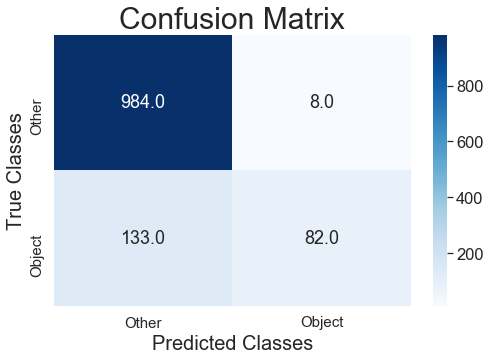

In [631]:
best_model_path = './SavedModel/Model.epoch_084-val_acc_0.8832.h5'
best_model = tf.keras.models.load_model(best_model_path)
predicted =best_model.predict(X_test_vec)
predicted_c = (predicted>0.5)
plot_evaluation(y_test, predicted_c)

## RUS

In [744]:
X = kl_email_esvl['Multi-Fields Processed'] # the features we want to analyze
ylabels = kl_email_esvl[''] # the labels, or answers, we want to test against
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=0, stratify=ylabels)#, shuffle=False)
print(X_train.shape,X_test.shape)
X_train_vec, X_test_vec = ngram_vectorize((X_train), (y_train), (X_test))
print(X_train_vec.shape)
print(y_train.sum(),y_test.sum())

(2814,) (1207,)
vocabulary length: 358682
(2814, 20000)
500 215


In [746]:
kl_email_esvl.head()

Folder  \
256463  _americas/asset_marketing   
256464  _americas/asset_marketing   
256465  _americas/asset_marketing   
256466  _americas/asset_marketing   
256467  _americas/asset_marketing   

                                   Multi-Fields_Processed  Labels  \
256463   asset market corpor develop jeff donahu louis...       9   
256464   conn coal plant dana davi david duran broderi...       9   
256465   peaker updat miller louis kitchen louis earli...       9   
256466   revis peaker action list march miller louis k...       9   
256467   gain calcul louis kitchen address louis reque...       9   

        Binary_Label  
256463             0  
256464             0  
256465             0  
256466             0  
256467             0

In [748]:
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_sample(X_train_vec, y_train)
print(X_rus.shape, y_rus.shape)
y_rus.sum()
data = (X_rus,y_rus),(X_test_vec,y_test)  
train_ngram_model0(data,2)

(1000, 20000) (1000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_39 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 20001     
Total params: 20,001
Trainable params: 20,001
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1207 samples
Epoch 1/1000

Epoch 00001: val_acc improved from -inf to 0.77299, saving model to ./SavedModel/Model.epoch_001-val_acc_0.7730.h5
 - 6s - loss: 0.6815 - acc: 0.7220 - val_loss: 0.6746 - val_acc: 0.7730
Epoch 2/1000

Epoch 00002: val_acc improved from 0.77299 to 0.80447, saving model to ./SavedModel/Model.epoch_002-val_acc_0.8045.h5
 - 2s - loss: 0.6400 - acc: 0.8750 - val_loss: 0.6524 - val_acc: 0.8045
Epoch 3/1000

Epoch 00003: val_acc improved from 0.80447 to


Epoch 00048: val_acc improved from 0.90307 to 0.90389, saving model to ./SavedModel/Model.epoch_048-val_acc_0.9039.h5
 - 1s - loss: 0.2083 - acc: 0.9520 - val_loss: 0.3130 - val_acc: 0.9039
Epoch 49/1000

Epoch 00049: val_acc did not improve from 0.90389
 - 1s - loss: 0.2076 - acc: 0.9560 - val_loss: 0.3121 - val_acc: 0.9039
Epoch 50/1000

Epoch 00050: val_acc did not improve from 0.90389
 - 2s - loss: 0.2053 - acc: 0.9550 - val_loss: 0.3100 - val_acc: 0.9022
Epoch 51/1000

Epoch 00051: val_acc did not improve from 0.90389
 - 1s - loss: 0.2044 - acc: 0.9540 - val_loss: 0.3089 - val_acc: 0.9022
Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.90389
 - 1s - loss: 0.1972 - acc: 0.9570 - val_loss: 0.3087 - val_acc: 0.9039
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.90389
 - 2s - loss: 0.1952 - acc: 0.9530 - val_loss: 0.3070 - val_acc: 0.9022
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.90389
 - 1s - loss: 0.1945 - acc: 0.9570 - val_loss: 0.3052 - val

Epoch 107/1000

Epoch 00107: val_acc did not improve from 0.90472
 - 1s - loss: 0.1240 - acc: 0.9710 - val_loss: 0.2768 - val_acc: 0.9014
Epoch 108/1000

Epoch 00108: val_acc did not improve from 0.90472
 - 1s - loss: 0.1259 - acc: 0.9690 - val_loss: 0.2766 - val_acc: 0.9006
Epoch 109/1000

Epoch 00109: val_acc did not improve from 0.90472
 - 1s - loss: 0.1266 - acc: 0.9700 - val_loss: 0.2761 - val_acc: 0.9006
Epoch 110/1000

Epoch 00110: val_acc did not improve from 0.90472
 - 1s - loss: 0.1271 - acc: 0.9700 - val_loss: 0.2761 - val_acc: 0.9014
Epoch 111/1000

Epoch 00111: val_acc did not improve from 0.90472
 - 1s - loss: 0.1230 - acc: 0.9740 - val_loss: 0.2760 - val_acc: 0.9022
Epoch 112/1000

Epoch 00112: val_acc did not improve from 0.90472
 - 1s - loss: 0.1211 - acc: 0.9690 - val_loss: 0.2756 - val_acc: 0.9014
Epoch 113/1000

Epoch 00113: val_acc did not improve from 0.90472
 - 1s - loss: 0.1223 - acc: 0.9710 - val_loss: 0.2758 - val_acc: 0.9014
Epoch 114/1000

Epoch 00114: val_a

Epoch 167/1000

Epoch 00167: val_acc did not improve from 0.90472
 - 1s - loss: 0.0971 - acc: 0.9720 - val_loss: 0.2730 - val_acc: 0.8964
Epoch 168/1000

Epoch 00168: val_acc did not improve from 0.90472
 - 2s - loss: 0.0947 - acc: 0.9750 - val_loss: 0.2730 - val_acc: 0.8964
Epoch 169/1000

Epoch 00169: val_acc did not improve from 0.90472
 - 1s - loss: 0.0996 - acc: 0.9700 - val_loss: 0.2730 - val_acc: 0.8964
Epoch 170/1000

Epoch 00170: val_acc did not improve from 0.90472
 - 1s - loss: 0.0919 - acc: 0.9790 - val_loss: 0.2730 - val_acc: 0.8956
Epoch 171/1000

Epoch 00171: val_acc did not improve from 0.90472
 - 2s - loss: 0.0893 - acc: 0.9730 - val_loss: 0.2728 - val_acc: 0.8956
Epoch 172/1000

Epoch 00172: val_acc did not improve from 0.90472
 - 2s - loss: 0.0952 - acc: 0.9710 - val_loss: 0.2728 - val_acc: 0.8956
Epoch 173/1000

Epoch 00173: val_acc did not improve from 0.90472
 - 1s - loss: 0.0938 - acc: 0.9750 - val_loss: 0.2729 - val_acc: 0.8964
Epoch 174/1000

Epoch 00174: val_a

Epoch 227/1000

Epoch 00227: val_acc did not improve from 0.90472
 - 2s - loss: 0.0738 - acc: 0.9790 - val_loss: 0.2769 - val_acc: 0.8948
Epoch 228/1000

Epoch 00228: val_acc did not improve from 0.90472
 - 2s - loss: 0.0754 - acc: 0.9780 - val_loss: 0.2770 - val_acc: 0.8948
Epoch 229/1000

Epoch 00229: val_acc did not improve from 0.90472
 - 1s - loss: 0.0786 - acc: 0.9800 - val_loss: 0.2771 - val_acc: 0.8948
Epoch 230/1000

Epoch 00230: val_acc did not improve from 0.90472
 - 1s - loss: 0.0785 - acc: 0.9810 - val_loss: 0.2773 - val_acc: 0.8948
Epoch 231/1000

Epoch 00231: val_acc did not improve from 0.90472
 - 2s - loss: 0.0689 - acc: 0.9840 - val_loss: 0.2773 - val_acc: 0.8948
Epoch 232/1000

Epoch 00232: val_acc did not improve from 0.90472
 - 2s - loss: 0.0690 - acc: 0.9820 - val_loss: 0.2774 - val_acc: 0.8948
Epoch 233/1000

Epoch 00233: val_acc did not improve from 0.90472
 - 1s - loss: 0.0748 - acc: 0.9810 - val_loss: 0.2775 - val_acc: 0.8948
Epoch 234/1000

Epoch 00234: val_a

(0.89560896, 0.2806341878717955)

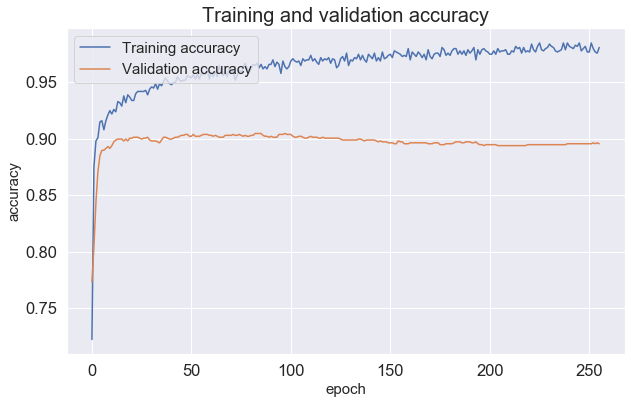

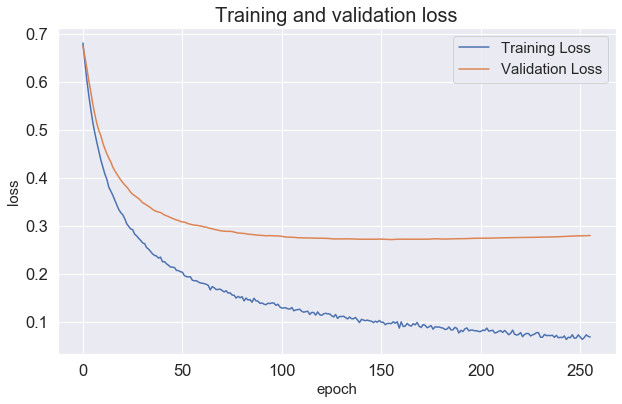

Accuracy: 0.9047224523612262
Precision: 0.8472222222222222
Recall: 0.5674418604651162
F1: 0.6796657381615598


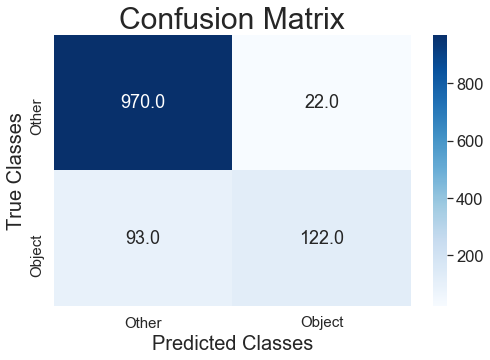

In [749]:
with open('./SavedModel/trainHistory', 'rb') as pickle_file:
    history_load = pickle.load(pickle_file)
plot_histrory(history_load)
best_model_path = './SavedModel/Model.epoch_083-val_acc_0.9047.h5'
best_model = tf.keras.models.load_model(best_model_path)
predicted =best_model.predict(X_test_vec)
predicted_c = (predicted>0.5)
plot_evaluation(y_test, predicted_c)

# case2

In [633]:
#Folder classification
kl_email_ooc = kl_email
kl_email_ooc[''] = list(map(int, kl_email_esvl['Folder']=='_americas/mrha/ooc')) 
print(kl_email_ooc[kl_email_ooc['']==1])
print(kl_email_esvl..value_counts())

                    Folder                             Multi-Fields_Processed  \
258747  _americas/mrha/ooc   bio louis kitchen rodney reagor louis version...   
258748  _americas/mrha/ooc   greenberg belfer et al andrew fastow sander b...   
258749  _americas/mrha/ooc   tabl report davi hugh shankman aaron armstron...   
258750  _americas/mrha/ooc   organ chang today form global servic eg order...   
258751  _americas/mrha/ooc   approv process entouch eric thode kathi grabs...   
...                    ...                                                ...   
259051  _americas/mrha/ooc   temporari space new build louis kitchen hall ...   
259052  _americas/mrha/ooc   new york dori hitchcock louis kitchen event t...   
259053  _americas/mrha/ooc   greater houston partnership articl cgordon ma...   
259054  _americas/mrha/ooc   fw manag confer home video project john lavor...   
259055  _americas/mrha/ooc   manag confer home video project shankman andr...   

        Labels  Binary_Labe

/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [634]:
X = kl_email_ooc['Multi-Fields Processed'] # the features we want to analyze
ylabels = kl_email_ooc[''] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=0, stratify=ylabels)#, shuffle=False)
print(X_train.shape,X_test.shape)

(2814,) (1207,)


In [636]:
#SMOTE
smote = SMOTE('minority', random_state=0)
X_train_vec, X_test_vec = ngram_vectorize((X_train), (y_train), (X_test))
print(X_train_vec.shape)
print(y_train.sum())
X_sm, y_sm = smote.fit_sample(X_train_vec, y_train)
print(X_sm.shape, y_sm.shape)
y_sm.sum()
data = (X_sm,y_sm),(X_test_vec,y_test)  
train_ngram_model0(data,2)

vocabulary length: 367307
(2814, 20000)
216
(5196, 20000) (5196,)
Train on 5196 samples, validate on 1207 samples
Epoch 1/1000

Epoch 00001: val_acc improved from -inf to 0.88567, saving model to ./SavedModel/Model.epoch_001-val_acc_0.8857.h5
 - 9s - loss: 0.5583 - acc: 0.8916 - val_loss: 0.5656 - val_acc: 0.8857
Epoch 2/1000

Epoch 00002: val_acc improved from 0.88567 to 0.89147, saving model to ./SavedModel/Model.epoch_002-val_acc_0.8915.h5
 - 6s - loss: 0.3882 - acc: 0.9677 - val_loss: 0.4418 - val_acc: 0.8915
Epoch 3/1000

Epoch 00003: val_acc did not improve from 0.89147
 - 6s - loss: 0.2986 - acc: 0.9696 - val_loss: 0.3818 - val_acc: 0.8906
Epoch 4/1000

Epoch 00004: val_acc did not improve from 0.89147
 - 8s - loss: 0.2440 - acc: 0.9702 - val_loss: 0.3503 - val_acc: 0.8890
Epoch 5/1000

Epoch 00005: val_acc did not improve from 0.89147
 - 7s - loss: 0.2082 - acc: 0.9729 - val_loss: 0.3316 - val_acc: 0.8882
Epoch 6/1000

Epoch 00006: val_acc did not improve from 0.89147
 - 7s - l


Epoch 00059: val_acc did not improve from 0.89147
 - 6s - loss: 0.0610 - acc: 0.9794 - val_loss: 0.5155 - val_acc: 0.8848
Epoch 60/1000

Epoch 00060: val_acc did not improve from 0.89147
 - 6s - loss: 0.0573 - acc: 0.9796 - val_loss: 0.5181 - val_acc: 0.8848
Epoch 61/1000

Epoch 00061: val_acc did not improve from 0.89147
 - 6s - loss: 0.0598 - acc: 0.9788 - val_loss: 0.5208 - val_acc: 0.8848
Epoch 62/1000

Epoch 00062: val_acc did not improve from 0.89147
 - 8s - loss: 0.0598 - acc: 0.9786 - val_loss: 0.5249 - val_acc: 0.8848
Epoch 63/1000

Epoch 00063: val_acc did not improve from 0.89147
 - 7s - loss: 0.0606 - acc: 0.9790 - val_loss: 0.5263 - val_acc: 0.8848
Epoch 64/1000

Epoch 00064: val_acc did not improve from 0.89147
 - 8s - loss: 0.0599 - acc: 0.9786 - val_loss: 0.5323 - val_acc: 0.8848
Epoch 65/1000

Epoch 00065: val_acc did not improve from 0.89147
 - 6s - loss: 0.0580 - acc: 0.9779 - val_loss: 0.5337 - val_acc: 0.8848
Epoch 66/1000

Epoch 00066: val_acc did not improve fro

(0.88483846, 0.6366294698470273)

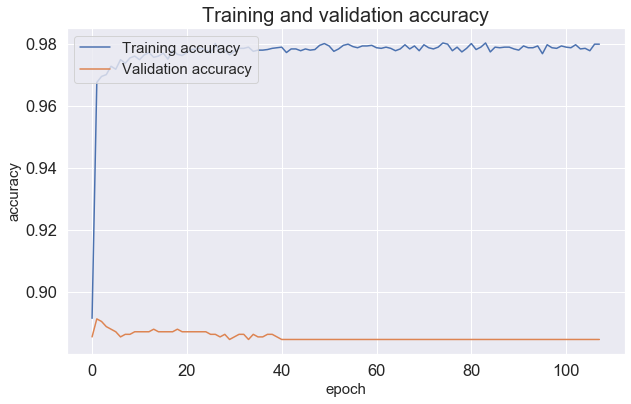

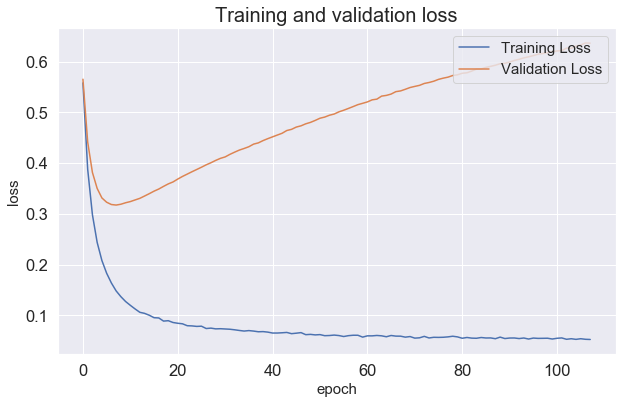

Logistic Regression Accuracy: 0.8914664457332229
Logistic Regression Precision: 0.2978723404255319
Logistic Regression Recall: 0.3010752688172043
Logistic Regression F1: 0.29946524064171126


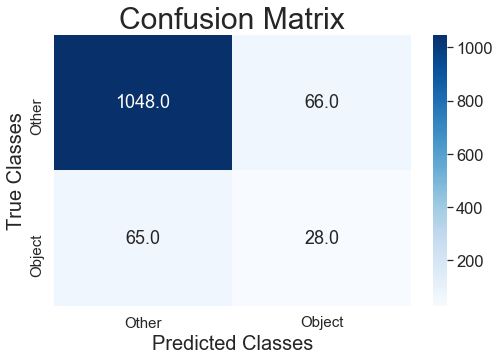

In [637]:
with open('./SavedModel/trainHistory', 'rb') as pickle_file:
    history_load = pickle.load(pickle_file)
plot_histrory(history_load)
best_model_path = './SavedModel/Model.epoch_002-val_acc_0.8915.h5'
best_model = tf.keras.models.load_model(best_model_path)
predicted =best_model.predict(X_test_vec)
predicted_c = (predicted>0.5)
plot_evaluation(y_test, predicted_c)

## RUS

In [639]:

rus = RandomUnderSampler(random_state=0)
X_train_vec, X_test_vec = ngram_vectorize((X_train), (y_train), (X_test))
print(X_train_vec.shape)
print(y_train.sum())
X_rus, y_rus = rus.fit_sample(X_train_vec, y_train)
print(X_rus.shape, y_rus.shape)
y_rus.sum()
data = (X_rus,y_rus),(X_test_vec,y_test)  
train_ngram_model0(data,2)

vocabulary length: 367307
(2814, 20000)
216
(432, 20000) (432,)
Train on 432 samples, validate on 1207 samples
Epoch 1/1000

Epoch 00001: val_acc improved from -inf to 0.81856, saving model to ./SavedModel/Model.epoch_001-val_acc_0.8186.h5
 - 5s - loss: 0.6872 - acc: 0.6690 - val_loss: 0.6846 - val_acc: 0.8186
Epoch 2/1000

Epoch 00002: val_acc did not improve from 0.81856
 - 1s - loss: 0.6485 - acc: 0.9167 - val_loss: 0.6847 - val_acc: 0.7589
Epoch 3/1000

Epoch 00003: val_acc did not improve from 0.81856
 - 1s - loss: 0.6130 - acc: 0.9120 - val_loss: 0.6765 - val_acc: 0.7995
Epoch 4/1000

Epoch 00004: val_acc improved from 0.81856 to 0.82022, saving model to ./SavedModel/Model.epoch_004-val_acc_0.8202.h5
 - 1s - loss: 0.5846 - acc: 0.9306 - val_loss: 0.6658 - val_acc: 0.8202
Epoch 5/1000

Epoch 00005: val_acc improved from 0.82022 to 0.83761, saving model to ./SavedModel/Model.epoch_005-val_acc_0.8376.h5
 - 1s - loss: 0.5563 - acc: 0.9630 - val_loss: 0.6548 - val_acc: 0.8376
Epoch 6/

Epoch 52/1000

Epoch 00052: val_acc did not improve from 0.89561
 - 1s - loss: 0.1630 - acc: 0.9838 - val_loss: 0.3628 - val_acc: 0.8923
Epoch 53/1000

Epoch 00053: val_acc did not improve from 0.89561
 - 1s - loss: 0.1586 - acc: 0.9861 - val_loss: 0.3617 - val_acc: 0.8923
Epoch 54/1000

Epoch 00054: val_acc did not improve from 0.89561
 - 1s - loss: 0.1563 - acc: 0.9815 - val_loss: 0.3604 - val_acc: 0.8923
Epoch 55/1000

Epoch 00055: val_acc did not improve from 0.89561
 - 1s - loss: 0.1549 - acc: 0.9769 - val_loss: 0.3594 - val_acc: 0.8923
Epoch 56/1000

Epoch 00056: val_acc did not improve from 0.89561
 - 1s - loss: 0.1503 - acc: 0.9838 - val_loss: 0.3585 - val_acc: 0.8923
Epoch 57/1000

Epoch 00057: val_acc did not improve from 0.89561
 - 1s - loss: 0.1483 - acc: 0.9838 - val_loss: 0.3577 - val_acc: 0.8923
Epoch 58/1000

Epoch 00058: val_acc did not improve from 0.89561
 - 1s - loss: 0.1493 - acc: 0.9792 - val_loss: 0.3568 - val_acc: 0.8923
Epoch 59/1000

Epoch 00059: val_acc did n

Epoch 112/1000

Epoch 00112: val_acc did not improve from 0.89561
 - 1s - loss: 0.0850 - acc: 0.9792 - val_loss: 0.3524 - val_acc: 0.8915
Epoch 113/1000

Epoch 00113: val_acc did not improve from 0.89561
 - 1s - loss: 0.0824 - acc: 0.9815 - val_loss: 0.3525 - val_acc: 0.8915
Epoch 114/1000

Epoch 00114: val_acc did not improve from 0.89561
 - 1s - loss: 0.0805 - acc: 0.9861 - val_loss: 0.3530 - val_acc: 0.8915
Epoch 115/1000

Epoch 00115: val_acc did not improve from 0.89561
 - 1s - loss: 0.0808 - acc: 0.9792 - val_loss: 0.3535 - val_acc: 0.8915
Epoch 116/1000

Epoch 00116: val_acc did not improve from 0.89561
 - 1s - loss: 0.0825 - acc: 0.9815 - val_loss: 0.3542 - val_acc: 0.8915
Epoch 117/1000

Epoch 00117: val_acc did not improve from 0.89561
 - 1s - loss: 0.0784 - acc: 0.9792 - val_loss: 0.3546 - val_acc: 0.8915
Epoch 118/1000

Epoch 00118: val_acc did not improve from 0.89561
 - 1s - loss: 0.0765 - acc: 0.9815 - val_loss: 0.3549 - val_acc: 0.8915
Epoch 119/1000

Epoch 00119: val_a

Epoch 172/1000

Epoch 00172: val_acc did not improve from 0.89561
 - 1s - loss: 0.0566 - acc: 0.9838 - val_loss: 0.3734 - val_acc: 0.8898
Epoch 173/1000

Epoch 00173: val_acc did not improve from 0.89561
 - 1s - loss: 0.0561 - acc: 0.9861 - val_loss: 0.3737 - val_acc: 0.8898
Epoch 174/1000

Epoch 00174: val_acc did not improve from 0.89561
 - 1s - loss: 0.0598 - acc: 0.9838 - val_loss: 0.3742 - val_acc: 0.8898
Epoch 175/1000

Epoch 00175: val_acc did not improve from 0.89561
 - 1s - loss: 0.0559 - acc: 0.9815 - val_loss: 0.3748 - val_acc: 0.8898
Epoch 176/1000

Epoch 00176: val_acc did not improve from 0.89561
 - 1s - loss: 0.0535 - acc: 0.9884 - val_loss: 0.3754 - val_acc: 0.8898
Epoch 177/1000

Epoch 00177: val_acc did not improve from 0.89561
 - 1s - loss: 0.0537 - acc: 0.9861 - val_loss: 0.3758 - val_acc: 0.8898
Epoch 178/1000

Epoch 00178: val_acc did not improve from 0.89561
 - 1s - loss: 0.0534 - acc: 0.9861 - val_loss: 0.3762 - val_acc: 0.8898
Epoch 179/1000

Epoch 00179: val_a

(0.8898094, 0.3783783881300821)

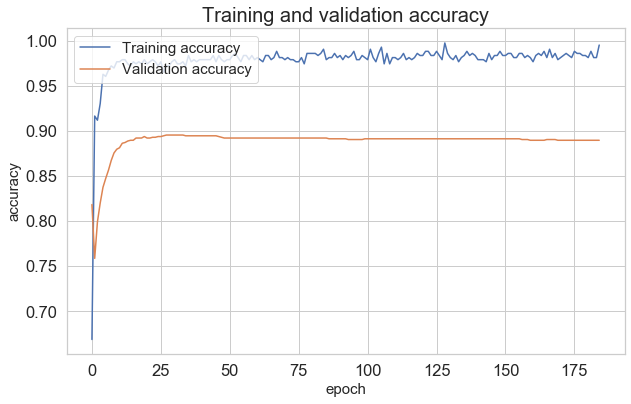

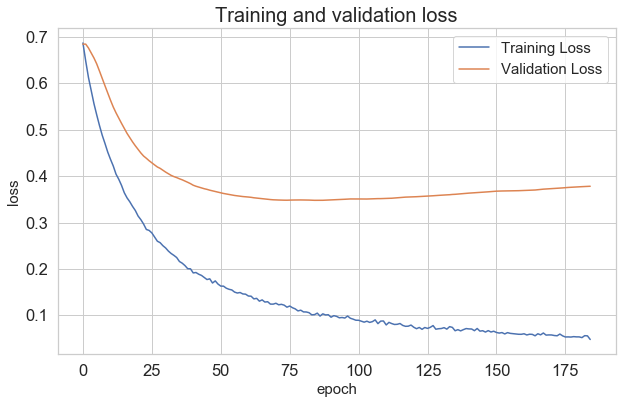

Logistic Regression Accuracy: 0.8956089478044739
Logistic Regression Precision: 0.32989690721649484
Logistic Regression Recall: 0.34408602150537637
Logistic Regression F1: 0.3368421052631579


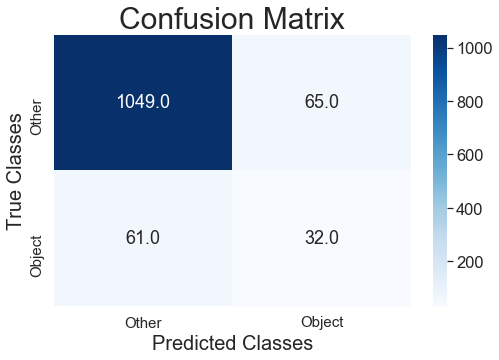

In [640]:
with open('./SavedModel/trainHistory', 'rb') as pickle_file:
    history_load = pickle.load(pickle_file)
plot_histrory(history_load)
best_model_path = './SavedModel/Model.epoch_028-val_acc_0.8956.h5'
best_model = tf.keras.models.load_model(best_model_path)
predicted =best_model.predict(X_test_vec)
predicted_c = (predicted>0.5)
plot_evaluation(y_test, predicted_c)